# **Pancreatic ccancer prediction with multi-class classification using Random Forest, Support Vector Machine and and Multilayer Perceptron**


Francesco Casini: francesco.casini4@studio.unibo.it

Basic and Advanced Machine Learning - University of Bologna Master in Bioinformatics (2024/2025)

# **1.Import libraries and modules**

These are the different python libraries and modules that have been used throughout the project:

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, recall_score, precision_score,
    matthews_corrcoef, roc_auc_score
)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import keras_tuner as kt



In [4]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# **2. Data retrieval**
The dataset is derived from a published paper: (*A combination of urinary biomarker panel and PancRISK score for earlier detection of pancreatic cancer: A case–control study*) (https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489).

 - Data table: A file containing information about patients

- Data description table: A table describing the features.

This is a multi-class classification problem, where the goal is to predict the diagnosis among three classes:

3: Pancreatic cancer

2: Non-cancerous pancreatic condition

1: Healthy



In [5]:
# Load the dataset and the description table
data = pd.read_csv('Debernardi et al 2020 data.csv')
data_description = pd.read_csv("Debernardi et al 2020 documentation.csv") 

In [6]:
pd.set_option('display.max_colwidth', None)
data_description = data_description.set_index('Column name')[['Details']]
data_description

,Details
Column name,
sample_id,Unique string identifying each subject
patient_cohort,"Cohort 1, previously used samples; Cohort 2, newly added samples"
sample_origin,"BPTB: Barts Pancreas Tissue Bank, London, UK; ESP: Spanish National Cancer Research Centre, Madrid, Spain; LIV: Liverpool University, UK; UCL: University College London, UK"
age,Age in years
sex,"M = male, F = female"
diagnosis,"1 = control (no pancreatic disease), 2 = benign hepatobiliary disease (119 of which are chronic pancreatitis); 3 = Pancreatic ductal adenocarcinoma, i.e. pancreatic cancer"
stage,"For those with pancratic cancer, what stage was it? One of IA, IB, IIA, IIIB, III, IV"
benign_sample_diagnosis,"For those with a benign, non-cancerous diagnosis, what was the diagnosis?"
plasma_CA19_9,Blood plasma levels of CA 19–9 monoclonal antibody that is often elevated in patients with pancreatic cancer. Only assessed in 350 patients (one goal of the study was to compare various CA 19-9 cutpoints from a blood sample to the model developed using urinary samples).


# **3.Data Exploration**



Upon inspecting the first few rows of the dataset, I notice the presence of NaN values, which I will address later 

In [7]:
data.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [9]:
data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
age,590.0,59.079661,13.109520,26.000000,50.000000,60.000000,69.000000,89.000000
diagnosis,590.0,2.027119,0.804873,1.000000,1.000000,2.000000,3.000000,3.000000
plasma_CA19_9,350.0,654.002944,2430.317642,0.000000,8.000000,26.500000,294.000000,31000.000000
creatinine,590.0,0.855383,0.639028,0.056550,0.373230,0.723840,1.139482,4.116840
LYVE1,590.0,3.063530,3.438796,0.000129,0.167179,1.649862,5.205037,23.890323
REG1B,590.0,111.774090,196.267110,0.001104,10.757216,34.303353,122.741013,1403.897600
TFF1,590.0,597.868722,1010.477245,0.005293,43.961000,259.873974,742.736000,13344.300000
REG1A,306.0,735.281222,1477.247724,0.000000,80.692000,208.538500,649.000000,13200.000000


## Univariate Exploration
Categorical and numerical features are separated to allow for specific univariate analysis. Distributions of each feature  are plotted to better understand their behavior, detect skewness, and identify potential class imbalances.



In [10]:
ctg_feat = data.select_dtypes(include='object').columns.tolist()
num_feat = data.select_dtypes(include='number').columns.tolist()

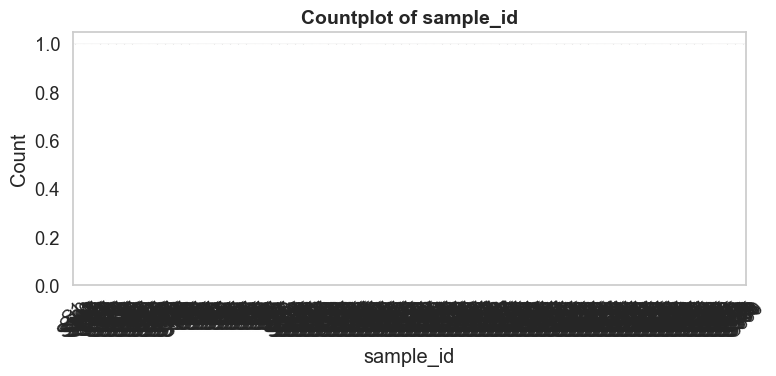

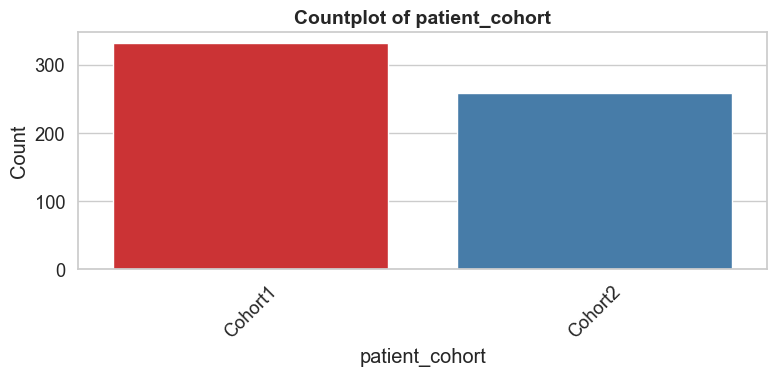

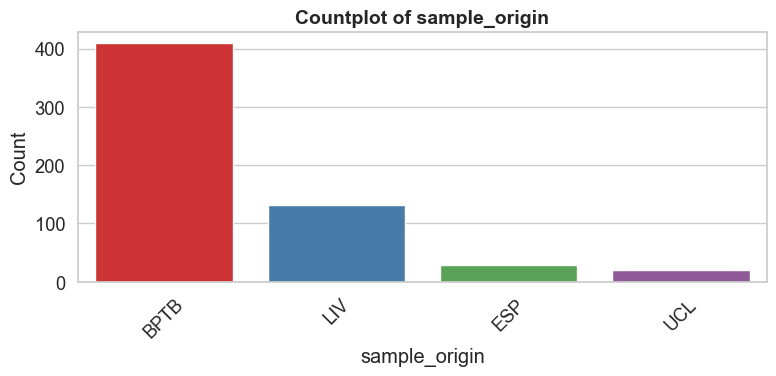

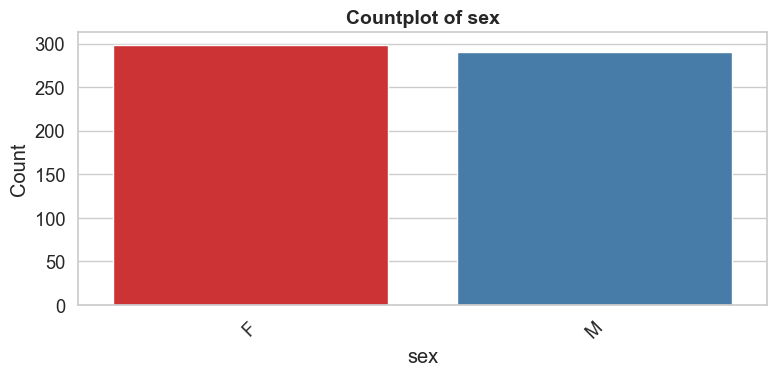

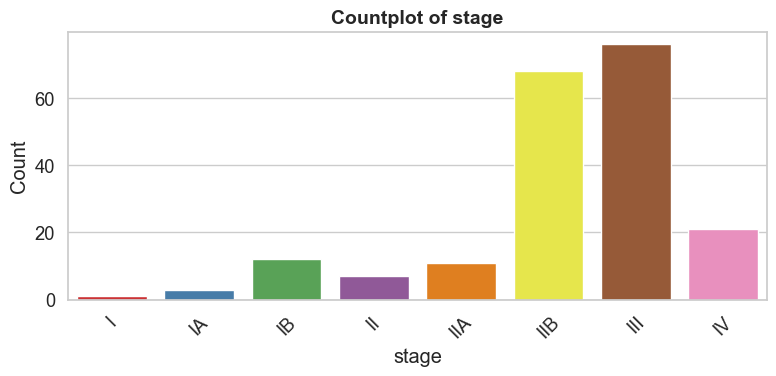

/var/folders/3w/ln6gq34d5334mr0rz50b0q840000gn/T/ipykernel_28713/441177961.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


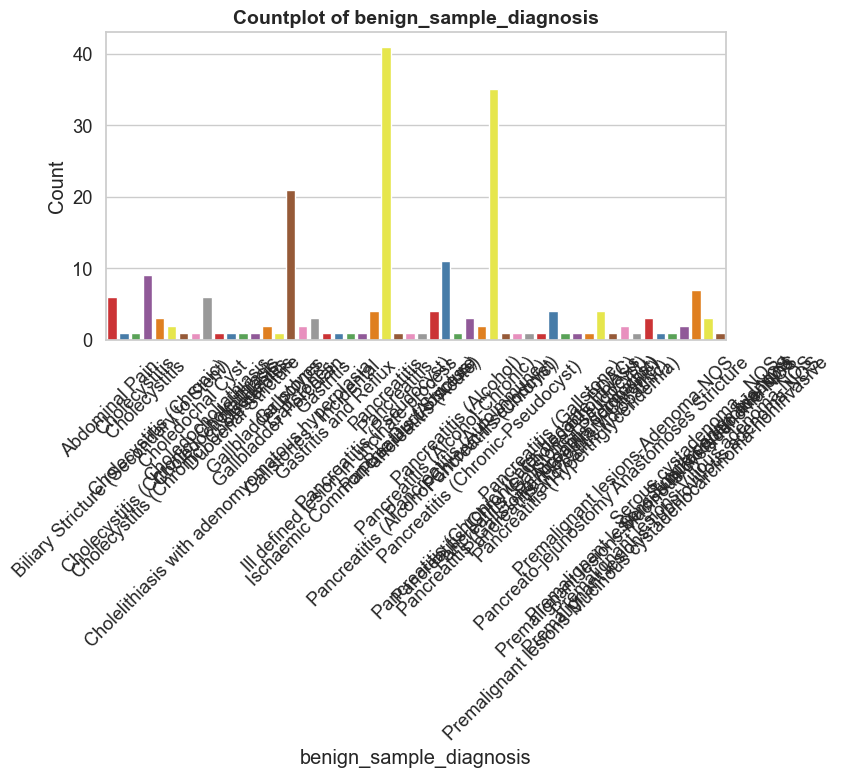

In [11]:
sns.set(style="whitegrid", palette="Set1", font_scale=1.2)

for feat in ctg_feat:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=feat, hue=feat, palette='Set1', legend=False)
    plt.title(f'Countplot of {feat}', fontsize=14, fontweight='bold')
    plt.ylabel('Count')
    plt.xlabel(feat)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

From the plots, we observe the following:

- Age appears to be approximately normally distributed.

- Class distribution is relatively well balanced across the three groups.

- Molecular markers exhibit a long right tail, indicating a right-skewed distribution. This means that the mean is typically greater than the median.

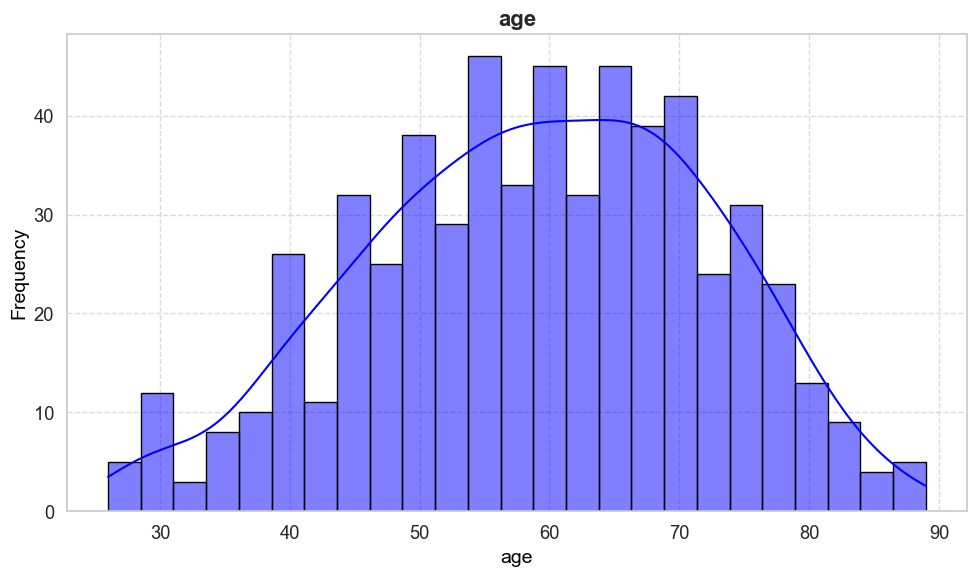

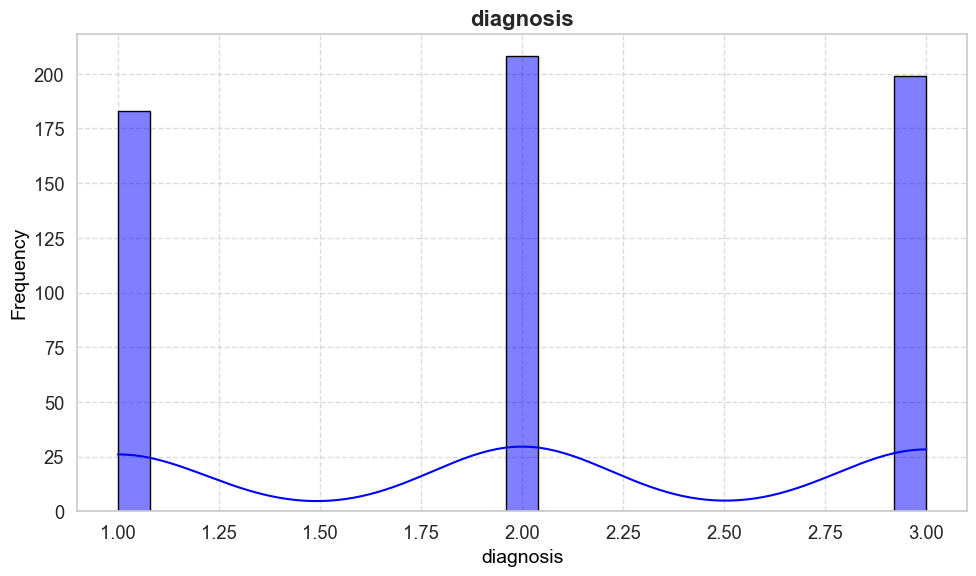

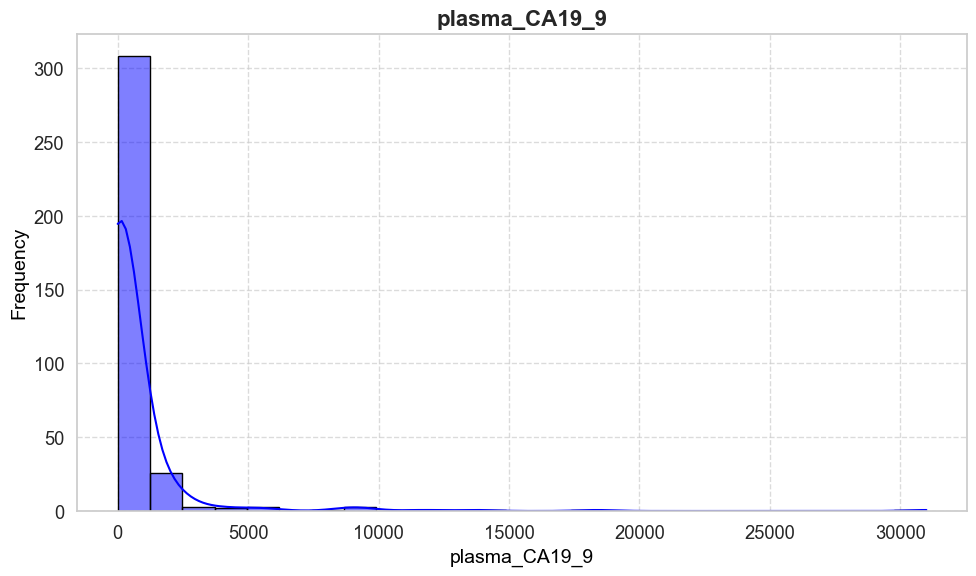

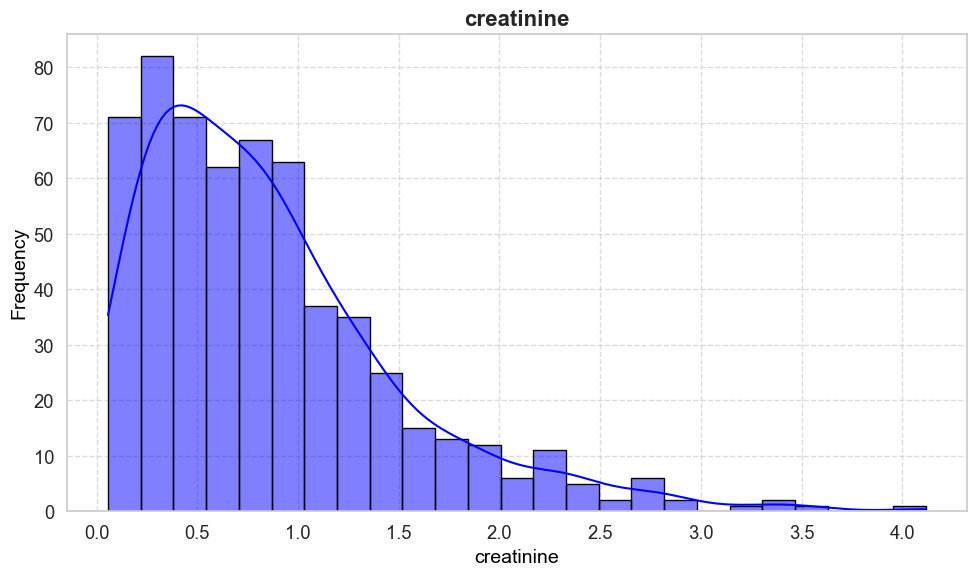

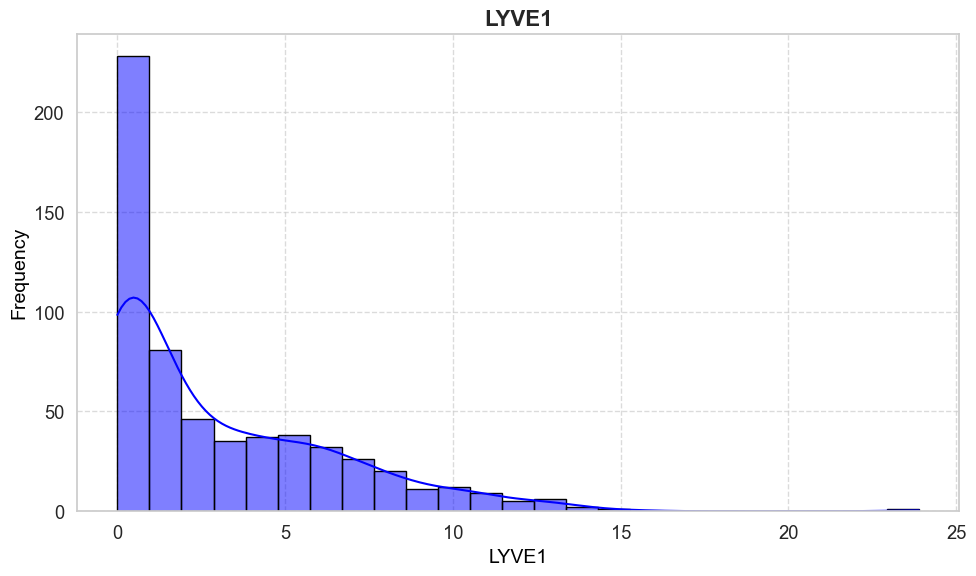

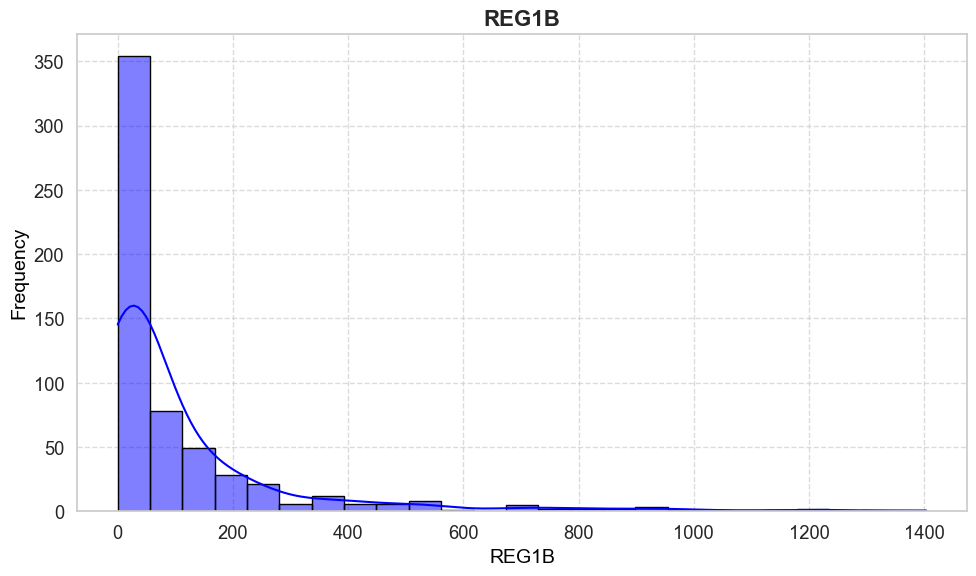

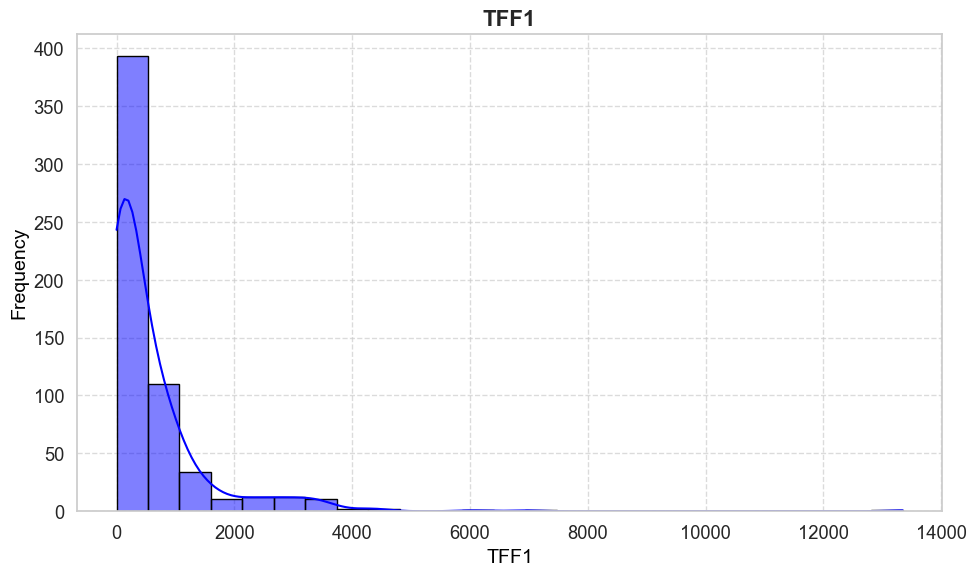

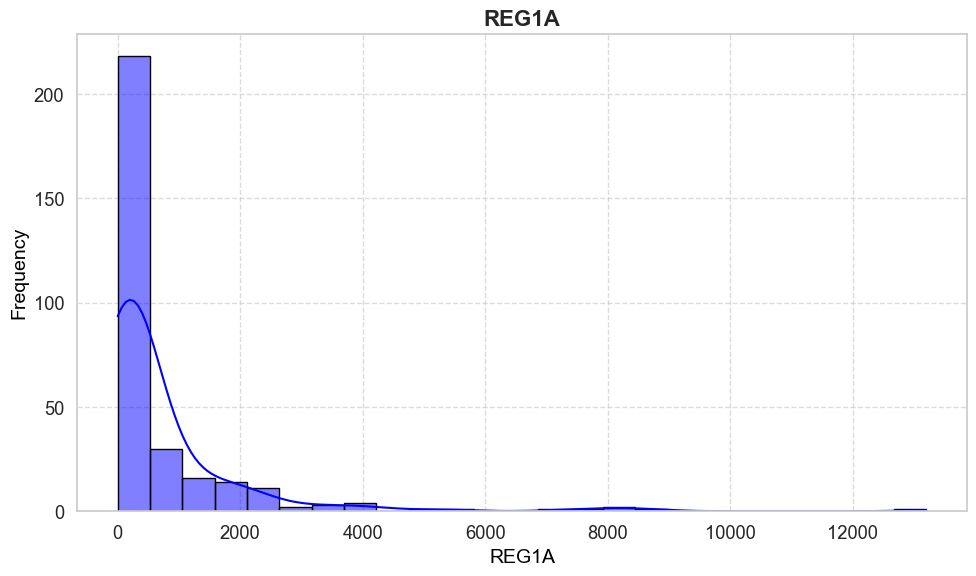

In [12]:
for feat in num_feat:
    plt.figure(figsize=(10, 6))

    sns.histplot(data=data, x=feat, kde=True, bins=25, color="blue", edgecolor="black")

    # Customize title and labels
    plt.title(feat, fontsize=16, fontweight='bold')
    plt.xlabel(feat, fontsize=14, color='black')
    plt.ylabel('Frequency', fontsize=14, color='black')

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()  
    plt.show()


In [13]:
diagnosis_table = data[num_feat].groupby('diagnosis').mean()
diagnosis_table

,age,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
diagnosis,,,,,,,
1,56.333333,8.749569,0.797633,1.212887,41.327901,169.024140,227.871886
2,54.701923,61.785741,0.847929,2.084612,64.174510,448.256897,547.458092
3,66.180905,1476.154733,0.916281,5.788567,226.308587,1148.611527,1138.323721


The stacked histograms illustrate the distribution of the diagnosis variable across the age and sex features.
The most common age range is around 60-70 years, with pancreatic cancer (3) more prevalent among the older population.

The overall number of males and females is similar, but diagnosis category 3 is slighlty more frequent in males, while diagnosis category 1 is more common among females.


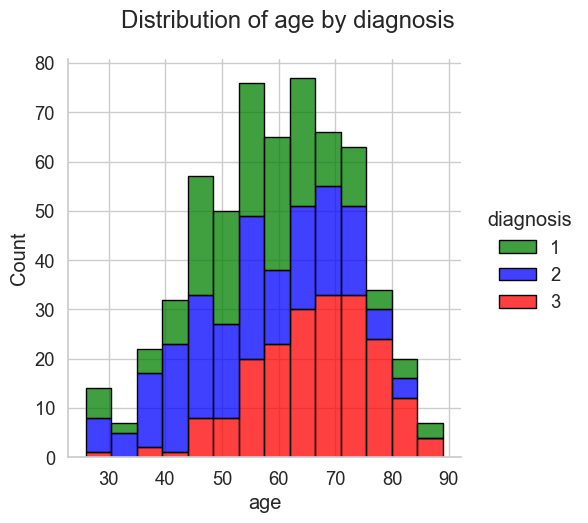

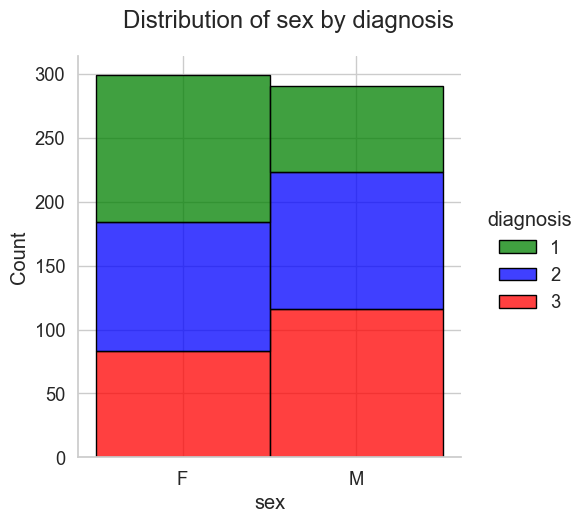

In [14]:
colors = {1: 'green', 2: 'blue', 3: 'red'}

for feature in ['age', 'sex']:
    g = sns.displot(data, x=feature, hue="diagnosis", multiple='stack', palette=colors, edgecolor='black')
    g.fig.suptitle(f'Distribution of {feature} by diagnosis', y=1.05)
    plt.show()


Class balance (for classification tasks).



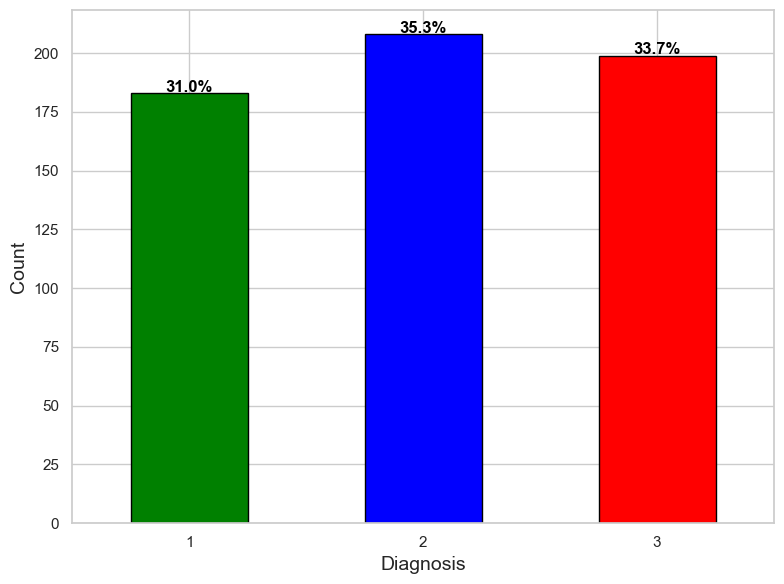

In [15]:
class_counts = data.groupby('diagnosis').size()
class_percentage = (class_counts / class_counts.sum()) * 100

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Map colors according to diagnosis classes
bar_colors = [colors.get(cls, 'gray') for cls in class_counts.index]

ax = class_counts.plot(kind='bar', color=bar_colors, edgecolor='black')

for index, value in enumerate(class_counts):
    percentage = class_percentage.iloc[index]  
    ax.text(index, value + 0.5, f"{percentage:.1f}%", ha='center', fontsize=12, fontweight='bold', color='black')

ax.set_xlabel('Diagnosis', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(class_counts.index, rotation=0)

plt.tight_layout()
plt.show()

# **4. Data preprocessing**
In the first section of the data preprocessing 4 steps have been perfomed in order to remove data that is either not usable or uninformative for the classification problem:

1.  **Inspecting and imputating missing values**

2.  **Outliers detection**

3.  **Dropping unnecessary columns**

4.  **Features encoding**

### 4.1 Inspecting missing values


In [16]:
data.isnull().sum()

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

In [17]:
# Create a list of the features containing missing values 
feature_na = []
for feature in data.columns:
    if data[feature].isnull().sum() > 0:
        feature_na.append(feature)

In [18]:
for feature in feature_na:
    perc_na = data[feature].isnull().mean() * 100  
    print("%s has %.2f%% of missing values" % (feature, perc_na))


stage has 66.27% of missing values
benign_sample_diagnosis has 64.75% of missing values
plasma_CA19_9 has 40.68% of missing values
REG1A has 48.14% of missing values


For each class, I inspect the distribution of numerical features to better understand their spread, detect potential outliers, and assess differences between groups. Additionally, I compute statistical annotations such as the mean and median to support the visual analysis.

In [19]:
def plot_boxplots_with_stats(data, num_feat, n_cols=2):
    ''' Generates boxplots for each numerical feature stratified by class, to visualize data distributions and detect outliers.
    In addition, mean and median values are printed for each feature. '''
    n_rows = math.ceil(len(num_feat) / n_cols)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6 * n_rows))  

    ax = ax.flatten()

    for i, col in enumerate(num_feat):
        sns.boxplot(x=data['diagnosis'], y=data[col], ax=ax[i])  
        
        mean_val = np.mean(data[col])
        median_val = np.nanmedian(data[col])
        
        print(f"{col} - Mean: {mean_val:.2f}, Median: {median_val:.2f}")
        
        ax[i].set_title(f"Feature: {col}", fontsize=14, fontweight='bold')
        ax[i].set_xlabel("Diagnosis")
        ax[i].set_ylabel(col)

    plt.tight_layout(pad=5.0)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()

For almost all features, the mean is significantly higher than the median, confirming a right-skewed distribution likely caused by extreme high values.
To mitigate the effect of outliers, missing values are replaced with the median rather than the mean. This is a common and effective strategy for handling skewed data, as the median is more robust to outliers.


age - Mean: 59.08, Median: 60.00
diagnosis - Mean: 2.03, Median: 2.00
plasma_CA19_9 - Mean: 654.00, Median: 26.50
creatinine - Mean: 0.86, Median: 0.72
LYVE1 - Mean: 3.06, Median: 1.65
REG1B - Mean: 111.77, Median: 34.30
TFF1 - Mean: 597.87, Median: 259.87
REG1A - Mean: 735.28, Median: 208.54


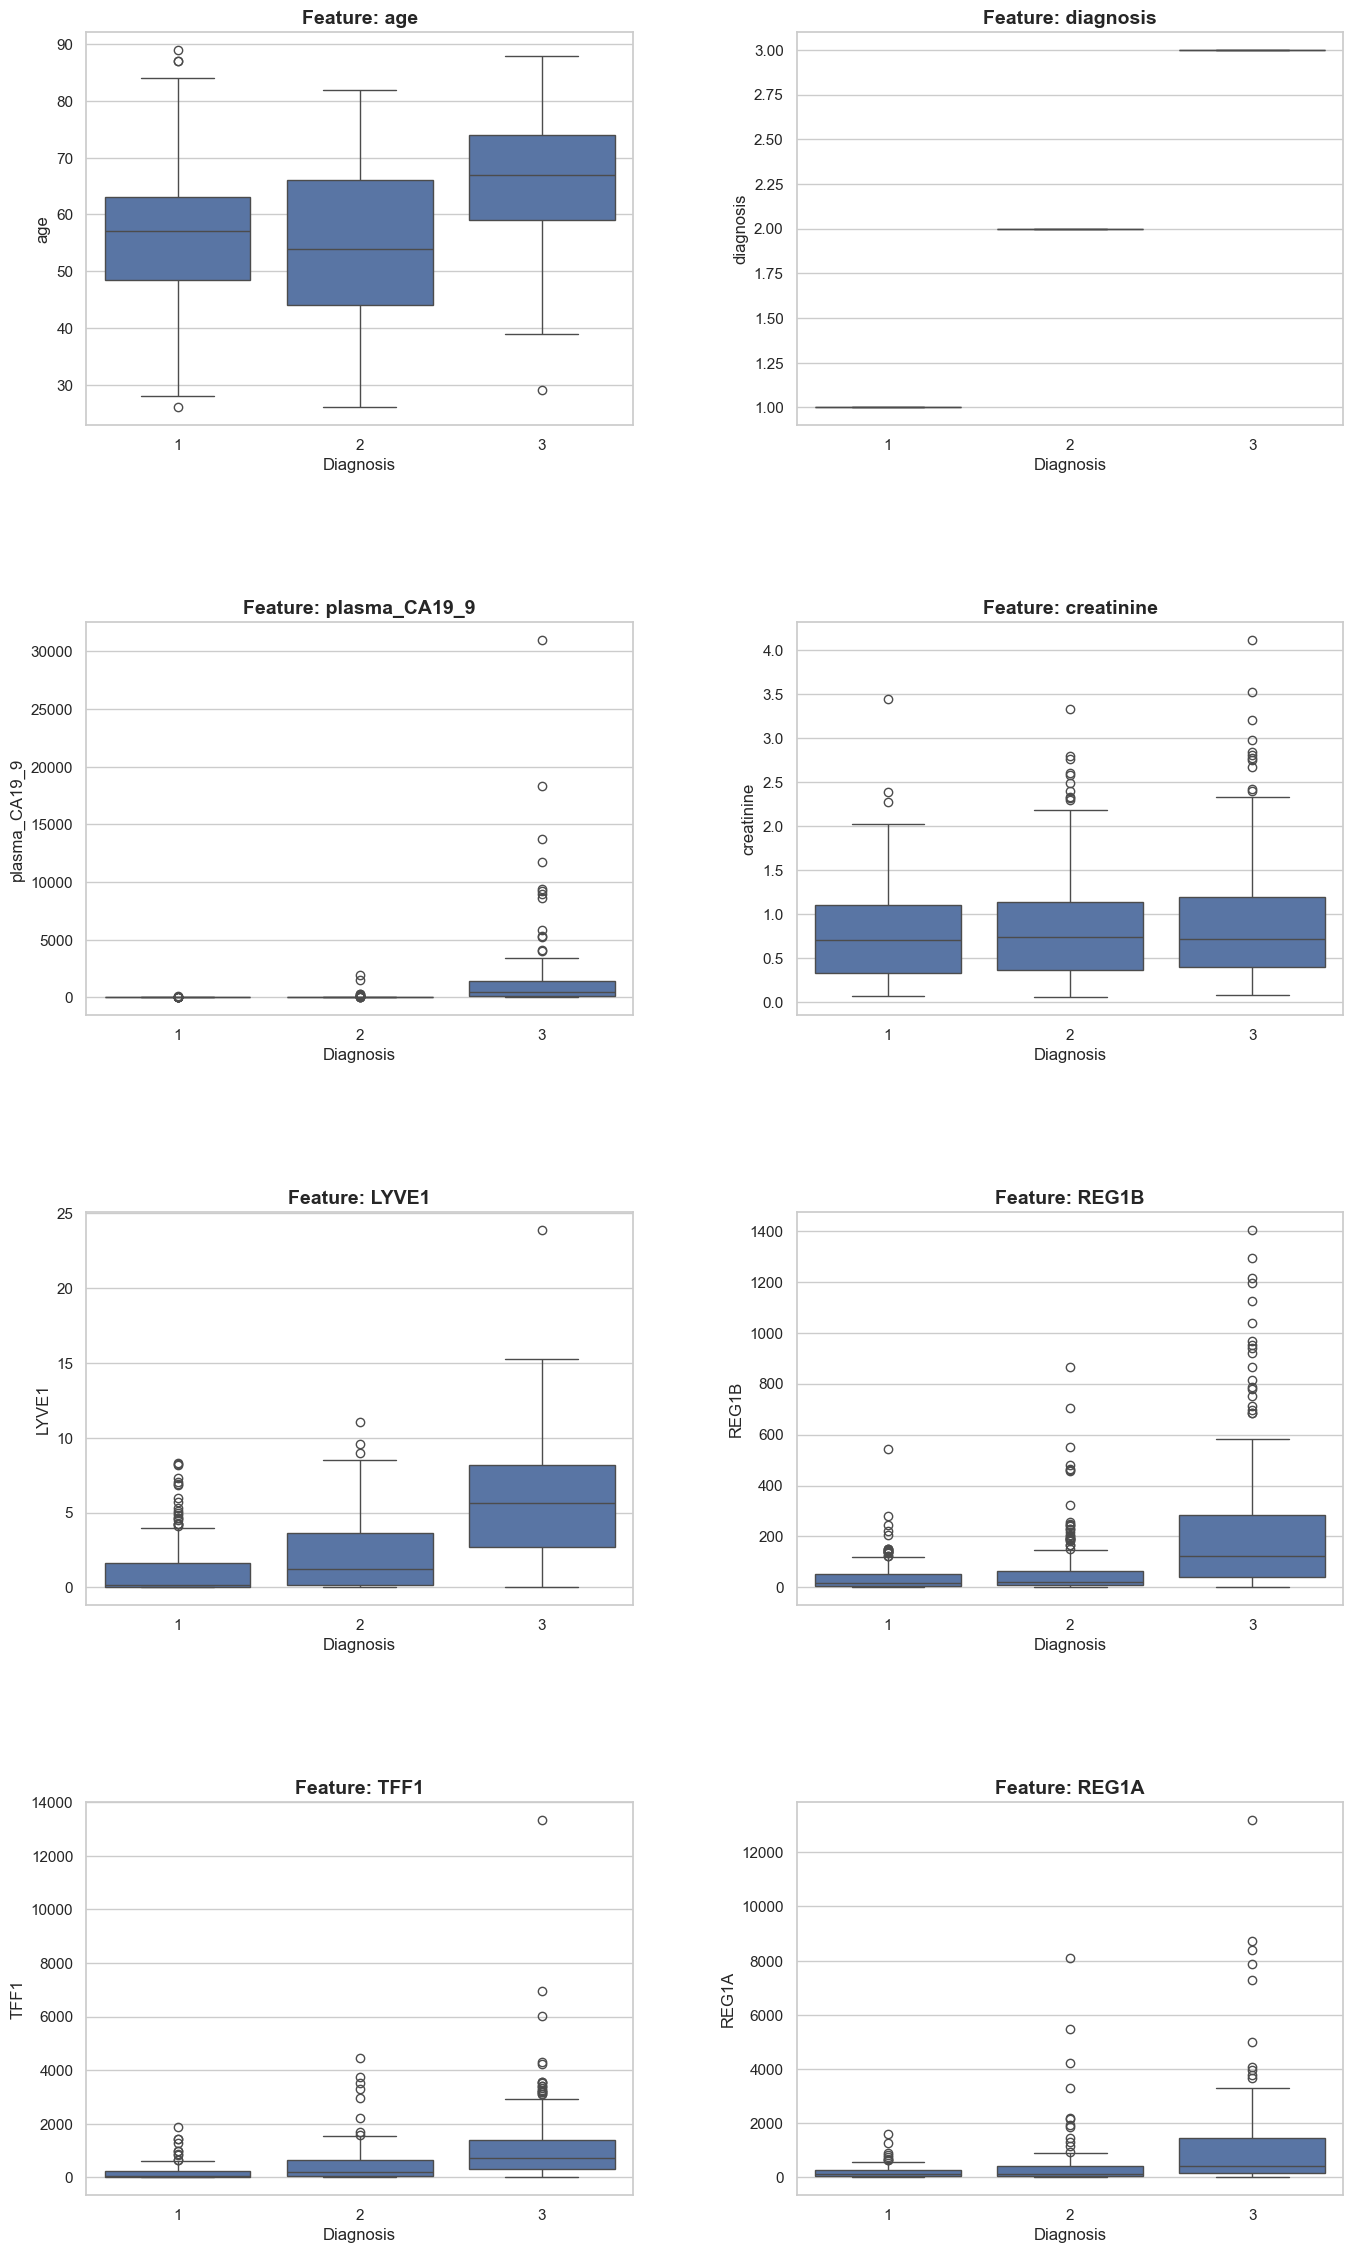

In [20]:
plot_boxplots_with_stats(data, num_feat)

In [21]:
data['plasma_CA19_9'] = data['plasma_CA19_9'].fillna(value=np.nanmedian(data['plasma_CA19_9']))
data['REG1A'] = data['REG1A'].fillna(value=np.nanmedian(data['REG1A']))

age - Mean: 59.08, Median: 60.00
diagnosis - Mean: 2.03, Median: 2.00
plasma_CA19_9 - Mean: 398.75, Median: 26.50
creatinine - Mean: 0.86, Median: 0.72
LYVE1 - Mean: 3.06, Median: 1.65
REG1B - Mean: 111.77, Median: 34.30
TFF1 - Mean: 597.87, Median: 259.87
REG1A - Mean: 481.73, Median: 208.54


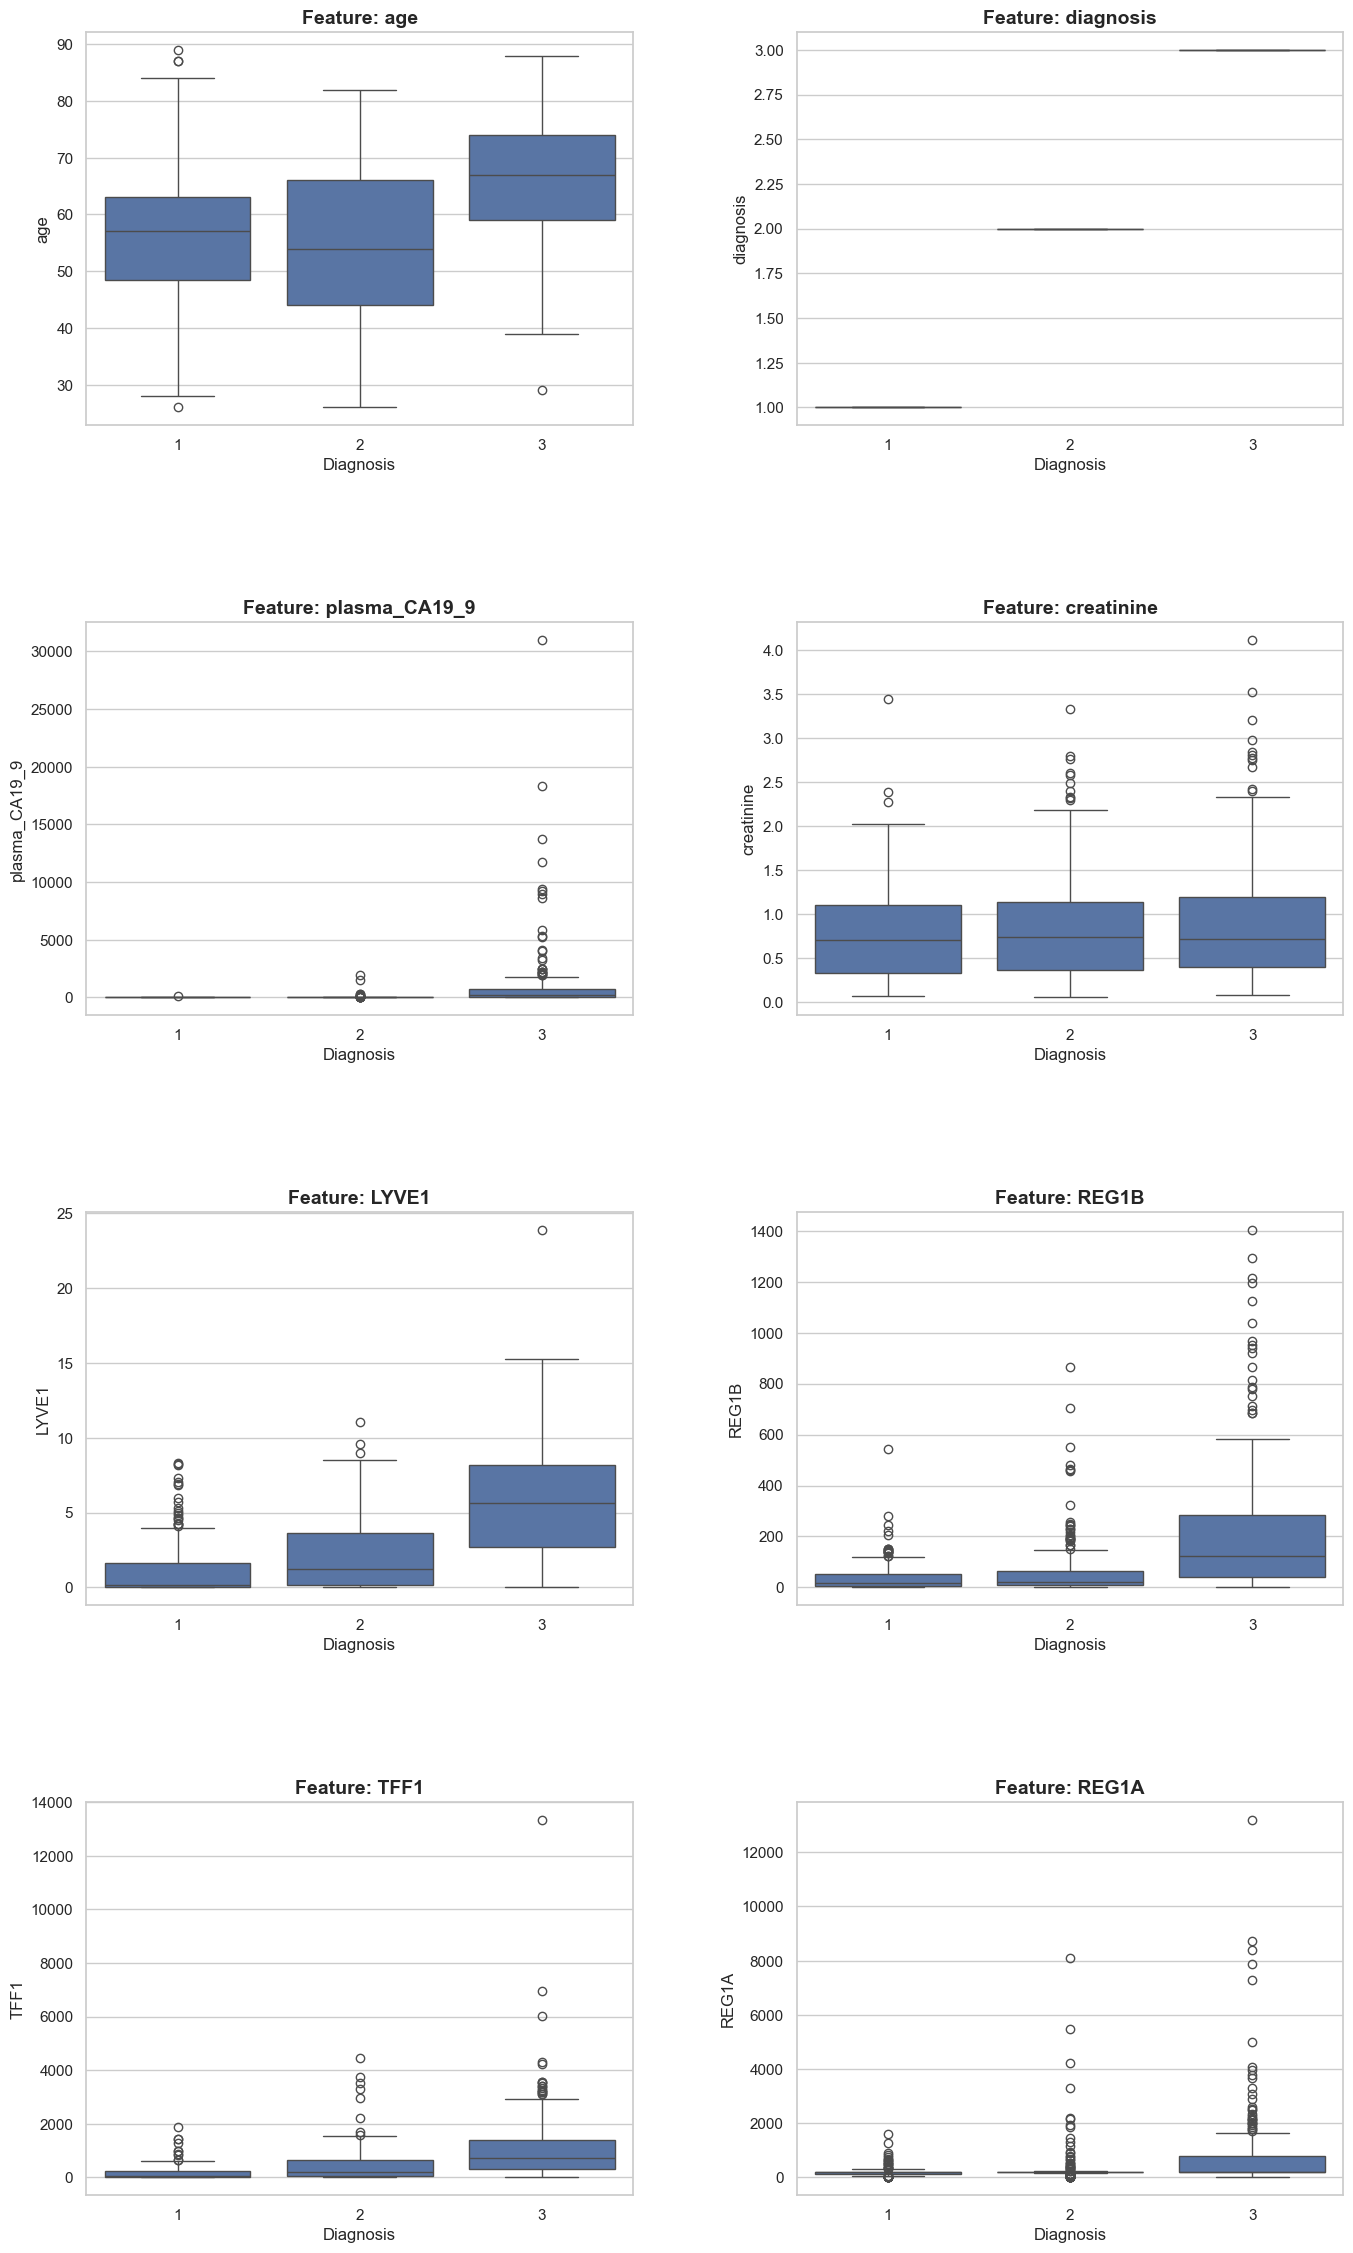

In [22]:
plot_boxplots_with_stats(data, num_feat)

 ### 4.2 Outliers detecting
 To handle outliers I calculate the first quartile (Q1) and the third quartile (Q3) of the features. Then compute the Interquartile Range (IQR) as the difference between Q3 and Q3:
 - The lower bound is defined as: Q1 - 1.5 * IQR
 - The upper bound is defined as: Q3 + 1.5 * IQR

Any values below the lower bound are considered outliers and are replaced with the lower bound and values above the upper bound are replaced with the upper bound.

In [23]:
def clip_outliers_iqr(df, columns):
    ''' Removes  outliers from specified features using the Interquartile Range method by clipping values outside the acceptable range.'''
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        #Clip values outside the lower and uppe bounds
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        
    return df

columns_to_clip = ['plasma_CA19_9', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']

data_clipped = data.copy()
data_clipped = clip_outliers_iqr(data_clipped, columns_to_clip)


age - Mean: 59.08, Median: 60.00
diagnosis - Mean: 2.03, Median: 2.00
plasma_CA19_9 - Mean: 398.75, Median: 26.50
creatinine - Mean: 0.86, Median: 0.72
LYVE1 - Mean: 3.06, Median: 1.65
REG1B - Mean: 111.77, Median: 34.30
TFF1 - Mean: 597.87, Median: 259.87
REG1A - Mean: 481.73, Median: 208.54


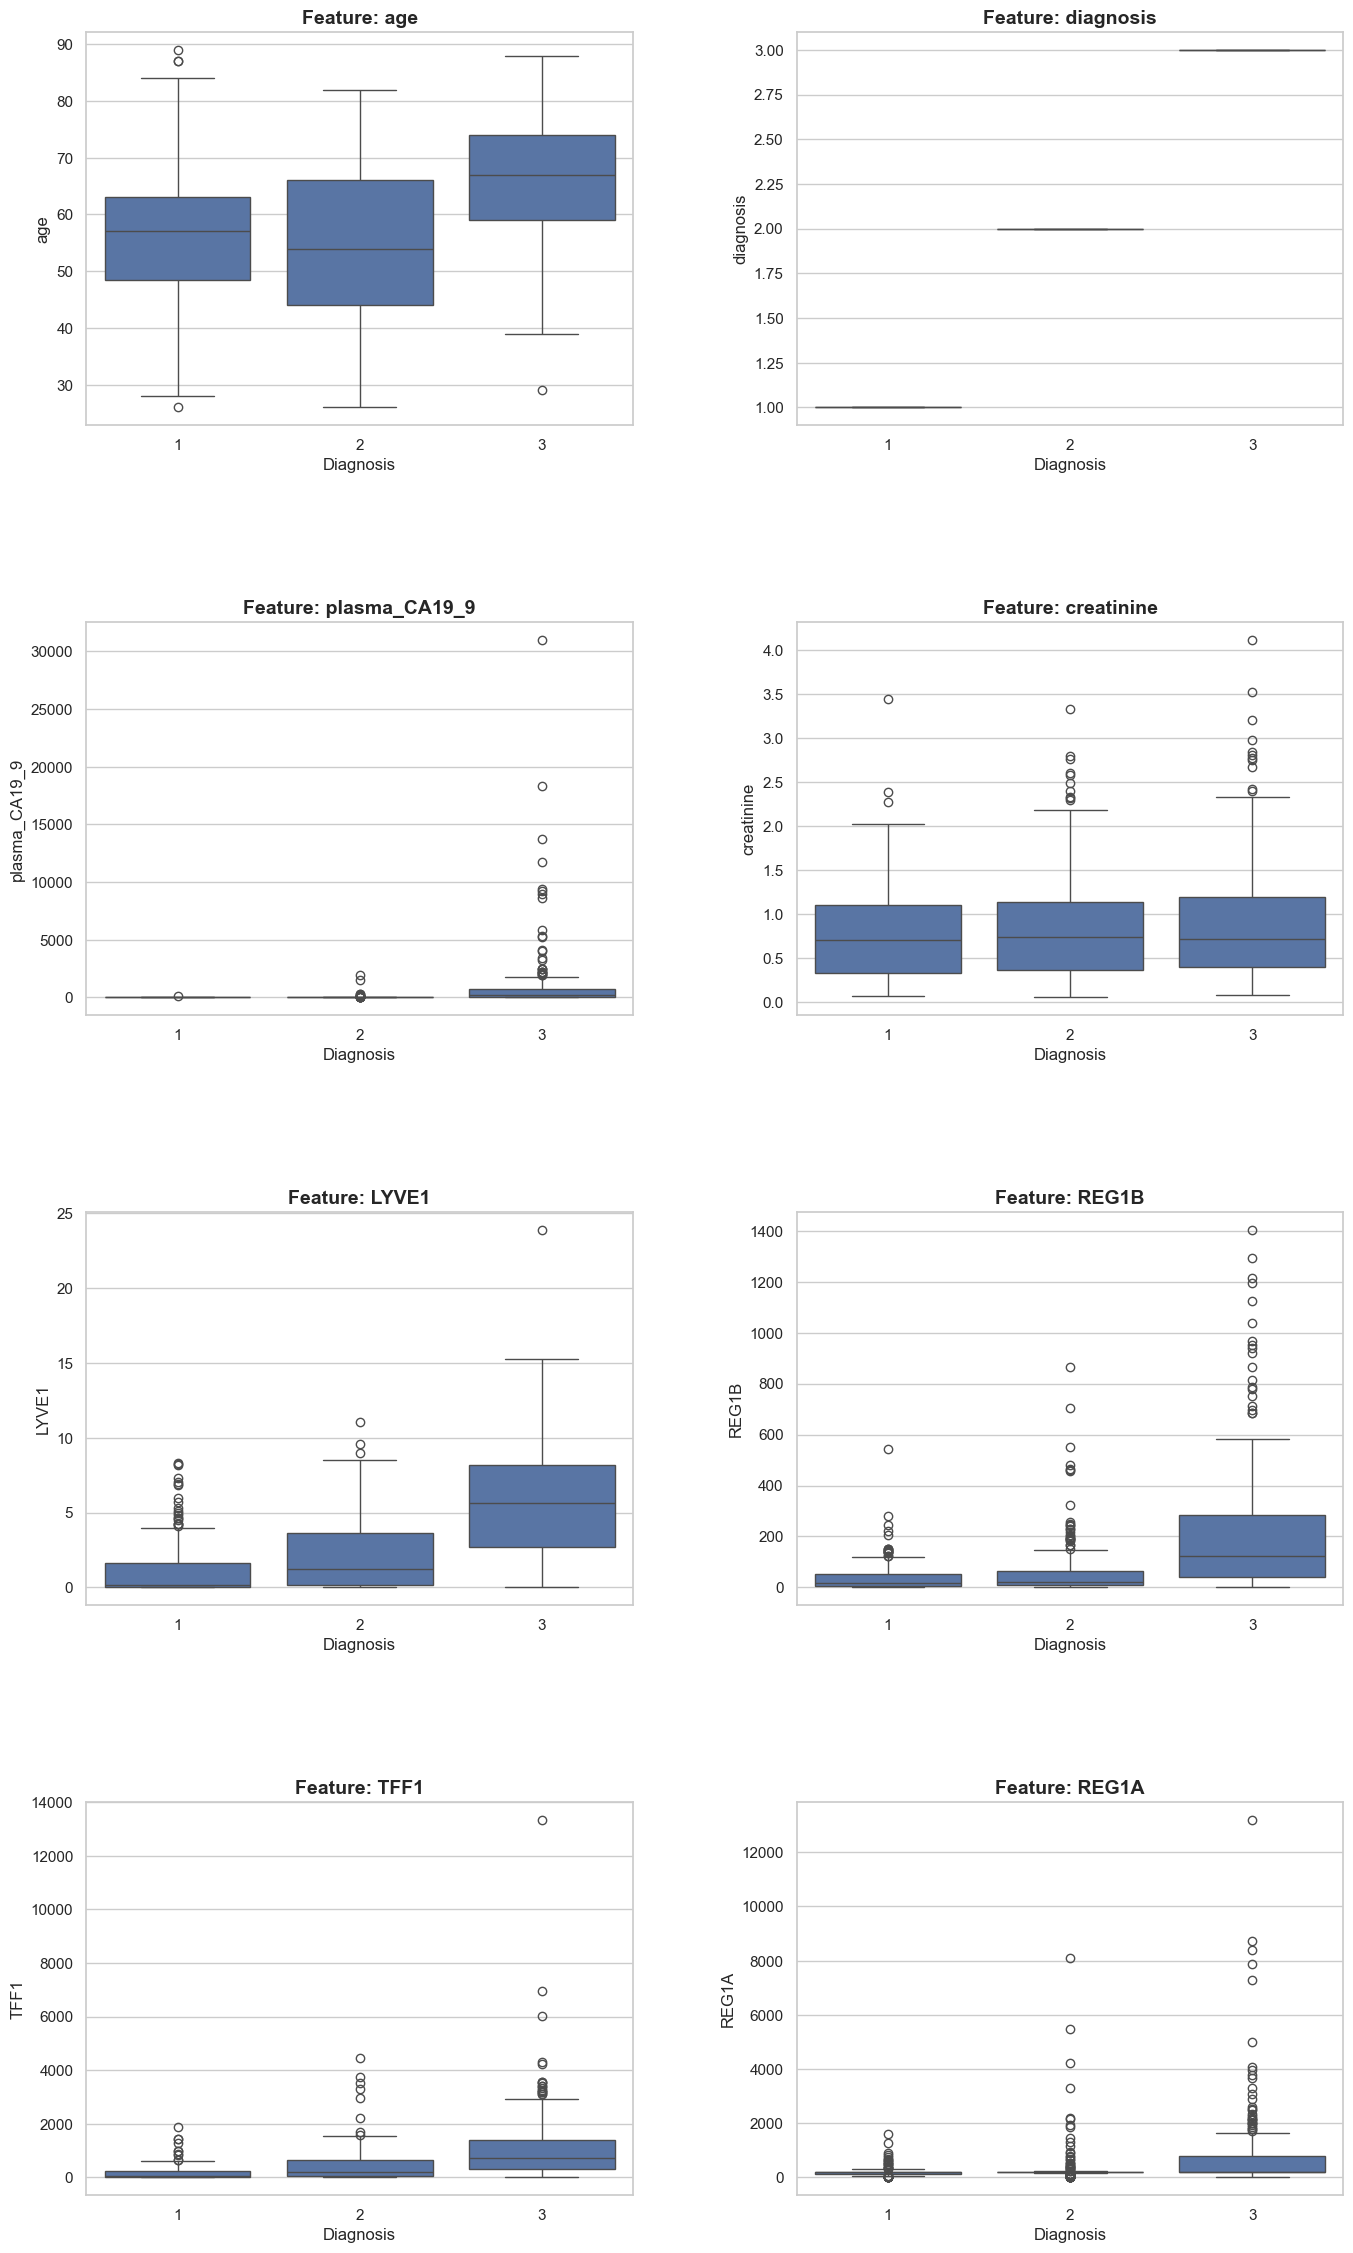

In [24]:
plot_boxplots_with_stats(data, num_feat)

age - Mean: 59.08, Median: 60.00
diagnosis - Mean: 2.03, Median: 2.00
plasma_CA19_9 - Mean: 34.02, Median: 26.50
creatinine - Mean: 0.86, Median: 0.72
LYVE1 - Mean: 3.04, Median: 1.65
REG1B - Mean: 80.71, Median: 34.30
TFF1 - Mean: 480.44, Median: 259.87
REG1A - Mean: 209.17, Median: 208.54


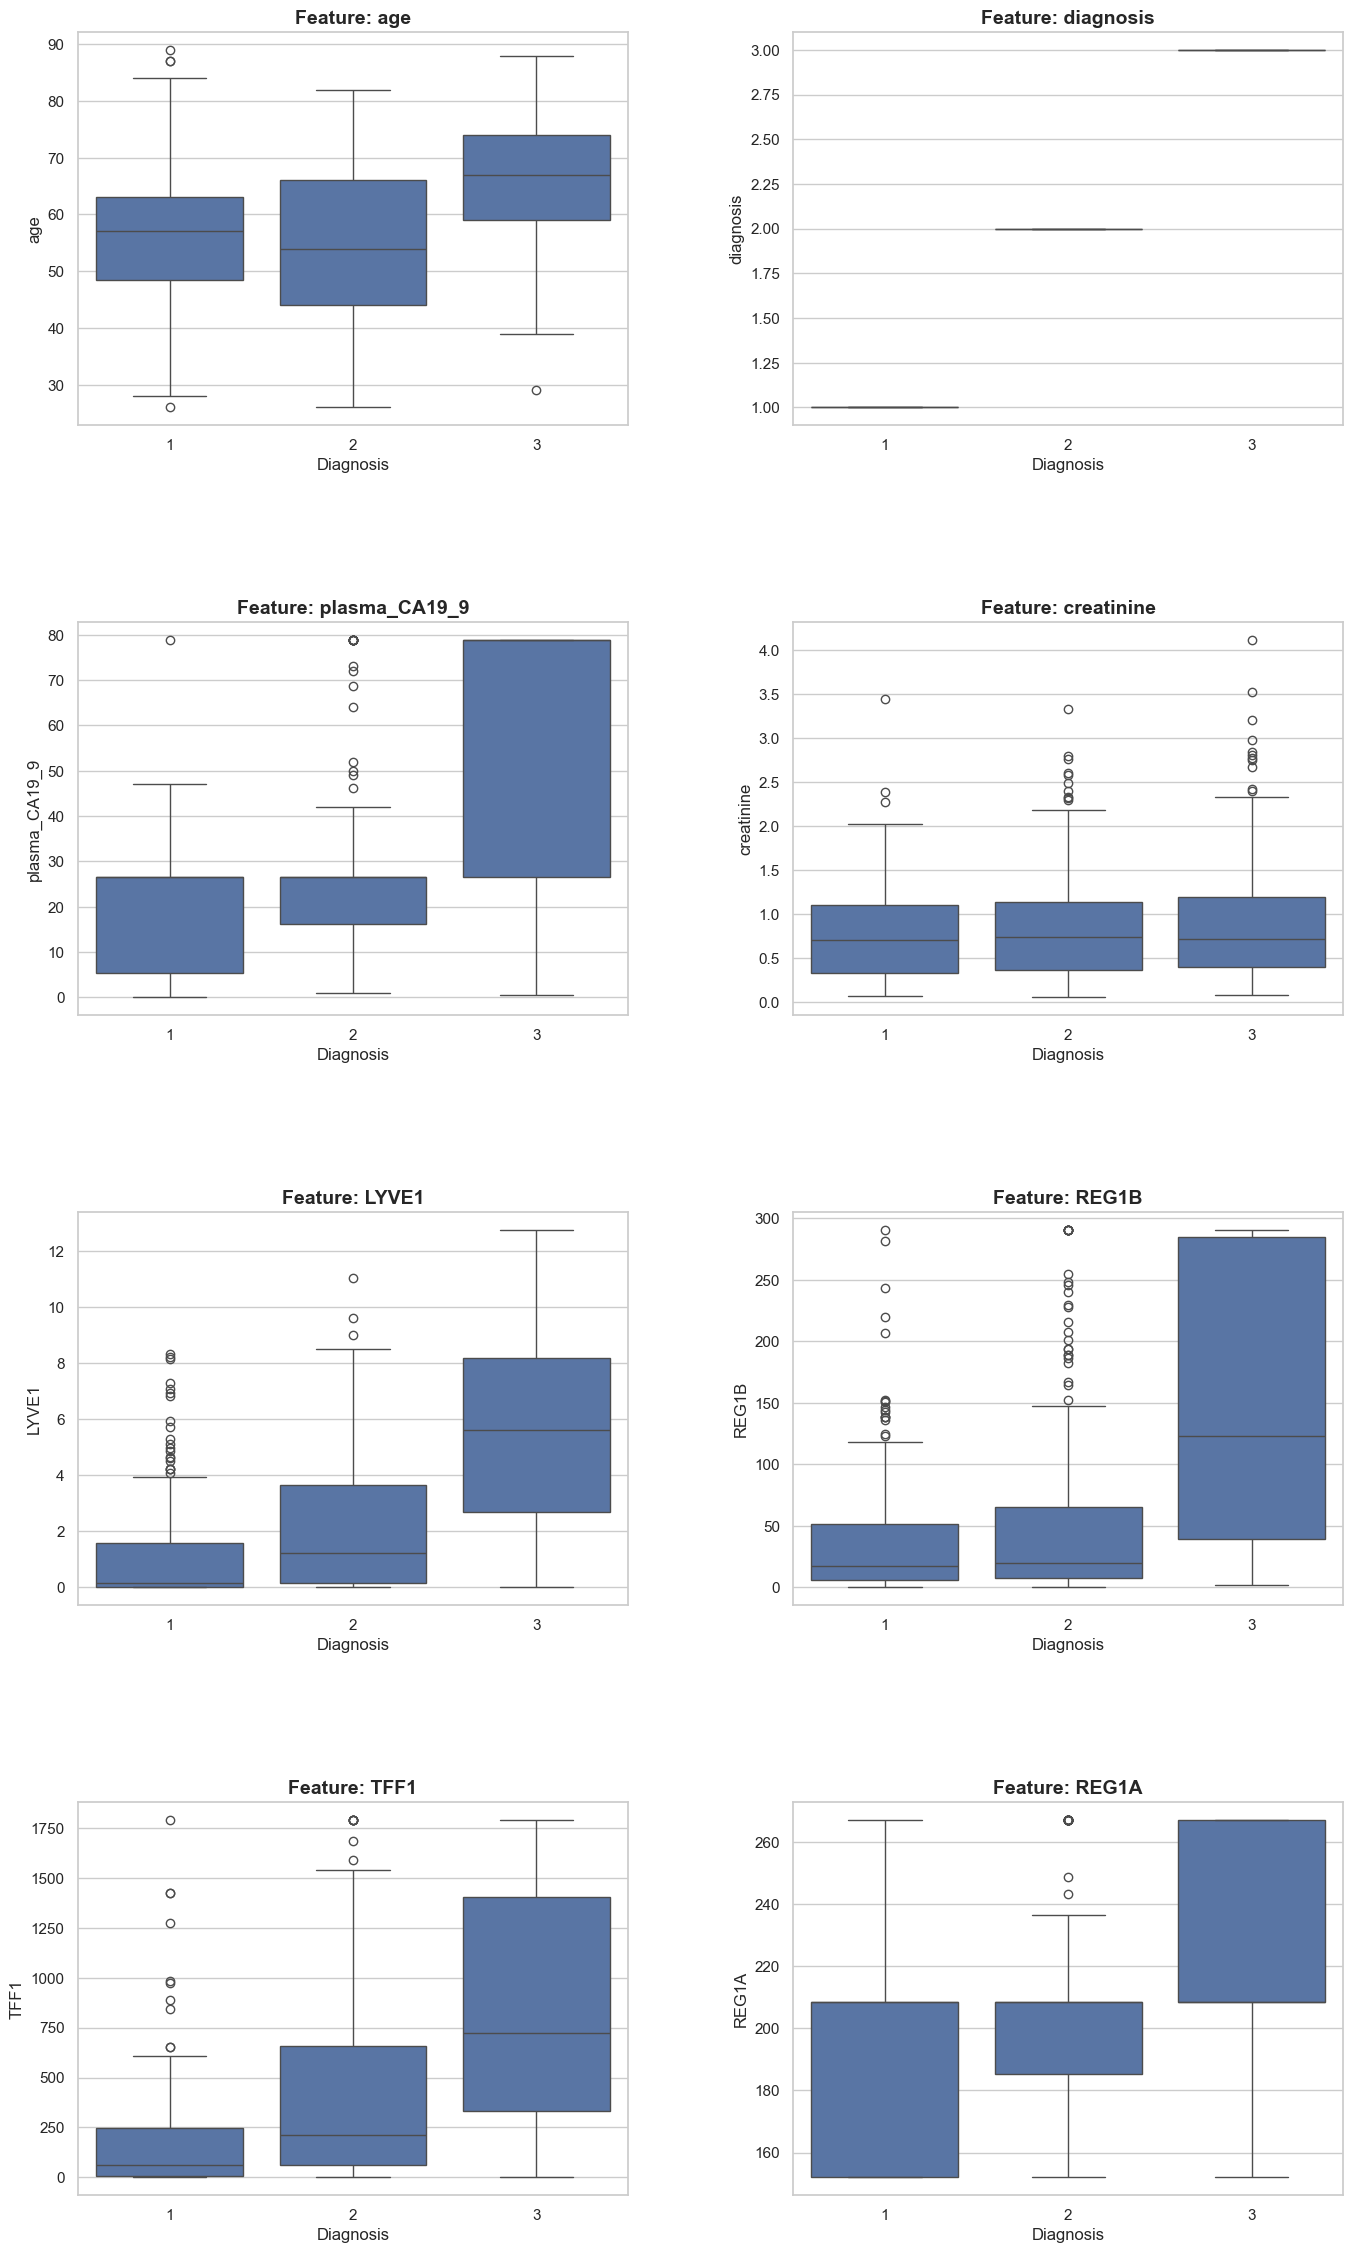

In [25]:
plot_boxplots_with_stats(data_clipped, num_feat)

### 4.3 Columns dropping
I inspect and eventually drop some features that don't contribute meaningfully to the prediction 



In [26]:
print(data_description.loc["benign_sample_diagnosis"].to_string())
data.benign_sample_diagnosis.value_counts()

Details    For those with a benign, non-cancerous diagnosis, what was the diagnosis?


benign_sample_diagnosis
Pancreatitis                                                    41
Pancreatitis (Chronic)                                          35
Gallstones                                                      21
Pancreatitis (Alcohol-Chronic)                                  11
Cholecystitis                                                    9
Serous cystadenoma - NOS                                         7
Choledocholiathiasis                                             6
Abdominal Pain                                                   6
Pancreatitis (Idiopathic)                                        4
Pancreatitis (Alcohol-Chronic-Pseuodcyst)                        4
Pancreatitis (Gallstone)                                         4
Pancreatitis (Pseudocyst)                                        4
Premalignant lesions-Mucinous cystadenoma-NOS                    3
Pancreatitis (Autoimmune)                                        3
Serous microcystic adenoma            

In [27]:

print(data_description.loc["stage"].to_string())
data.stage.value_counts()

Details    For those with pancratic cancer, what stage was it? One of IA, IB, IIA, IIIB, III, IV


stage
III    76
IIB    68
IV     21
IB     12
IIA    11
II      7
IA      3
I       1
Name: count, dtype: int64

In [28]:
print(data_description.loc["sample_id"].to_string())
data.sample_id.value_counts()

Details    Unique string identifying each subject


sample_id
S1      1
S588    1
S302    1
S288    1
S497    1
       ..
S282    1
S321    1
S323    1
S363    1
S590    1
Name: count, Length: 590, dtype: int64

In [29]:
print(data_description.loc["sample_origin"].to_string())
data.sample_origin.value_counts()

Details    BPTB: Barts Pancreas Tissue Bank, London, UK; ESP: Spanish National Cancer Research Centre, Madrid, Spain; LIV: Liverpool University, UK; UCL: University College London, UK


sample_origin
BPTB    409
LIV     132
ESP      29
UCL      20
Name: count, dtype: int64

In [30]:
col_to_drop = ["benign_sample_diagnosis", "stage", "sample_id", "patient_cohort", "sample_origin"]
data.drop(columns=col_to_drop, inplace=True)


In [31]:
data

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,F,1,11.7,1.83222,0.893219,52.948840,654.282174,1262.0000
1,81,F,1,26.5,0.97266,2.037585,94.467030,209.488250,228.4070
2,51,M,1,7.0,0.78039,0.145589,102.366000,461.141000,208.5385
3,61,M,1,8.0,0.70122,0.002805,60.579000,142.950000,208.5385
4,62,M,1,9.0,0.21489,0.000860,65.540000,41.088000,208.5385
...,...,...,...,...,...,...,...,...,...
585,68,M,3,26.5,0.52026,7.058209,156.241000,525.178000,208.5385
586,71,F,3,26.5,0.85956,8.341207,16.915000,245.947000,208.5385
587,63,M,3,26.5,1.36851,7.674707,289.701000,537.286000,208.5385
588,75,F,3,26.5,1.33458,8.206777,205.930000,722.523000,208.5385


In [32]:
data.isna().sum()

age              0
sex              0
diagnosis        0
plasma_CA19_9    0
creatinine       0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
dtype: int64

### 4.4 Feature encoding
Feature encoding is the process of converting categorical data into a numerical format. The sex features will be transformed in 0 or 1 


In [33]:
label_encoder = LabelEncoder()
data.sex = label_encoder.fit_transform(data.sex)


# **5. Features correlation**

In [34]:
data.head()

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,0,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.0000
1,81,0,1,26.5,0.97266,2.037585,94.46703,209.488250,228.4070
2,51,1,1,7.0,0.78039,0.145589,102.36600,461.141000,208.5385
3,61,1,1,8.0,0.70122,0.002805,60.57900,142.950000,208.5385
4,62,1,1,9.0,0.21489,0.000860,65.54000,41.088000,208.5385


The pairplot reveals non-linear relationships among features, with heavy class overlap in most scatter plots. Scatter plots show how pairs of features relate across classes and we can see that here's no clear linear separation between classes for any pair of features.
Feature distributions are skewed and vary by class, indicating the presence of outliers and differing data ranges.

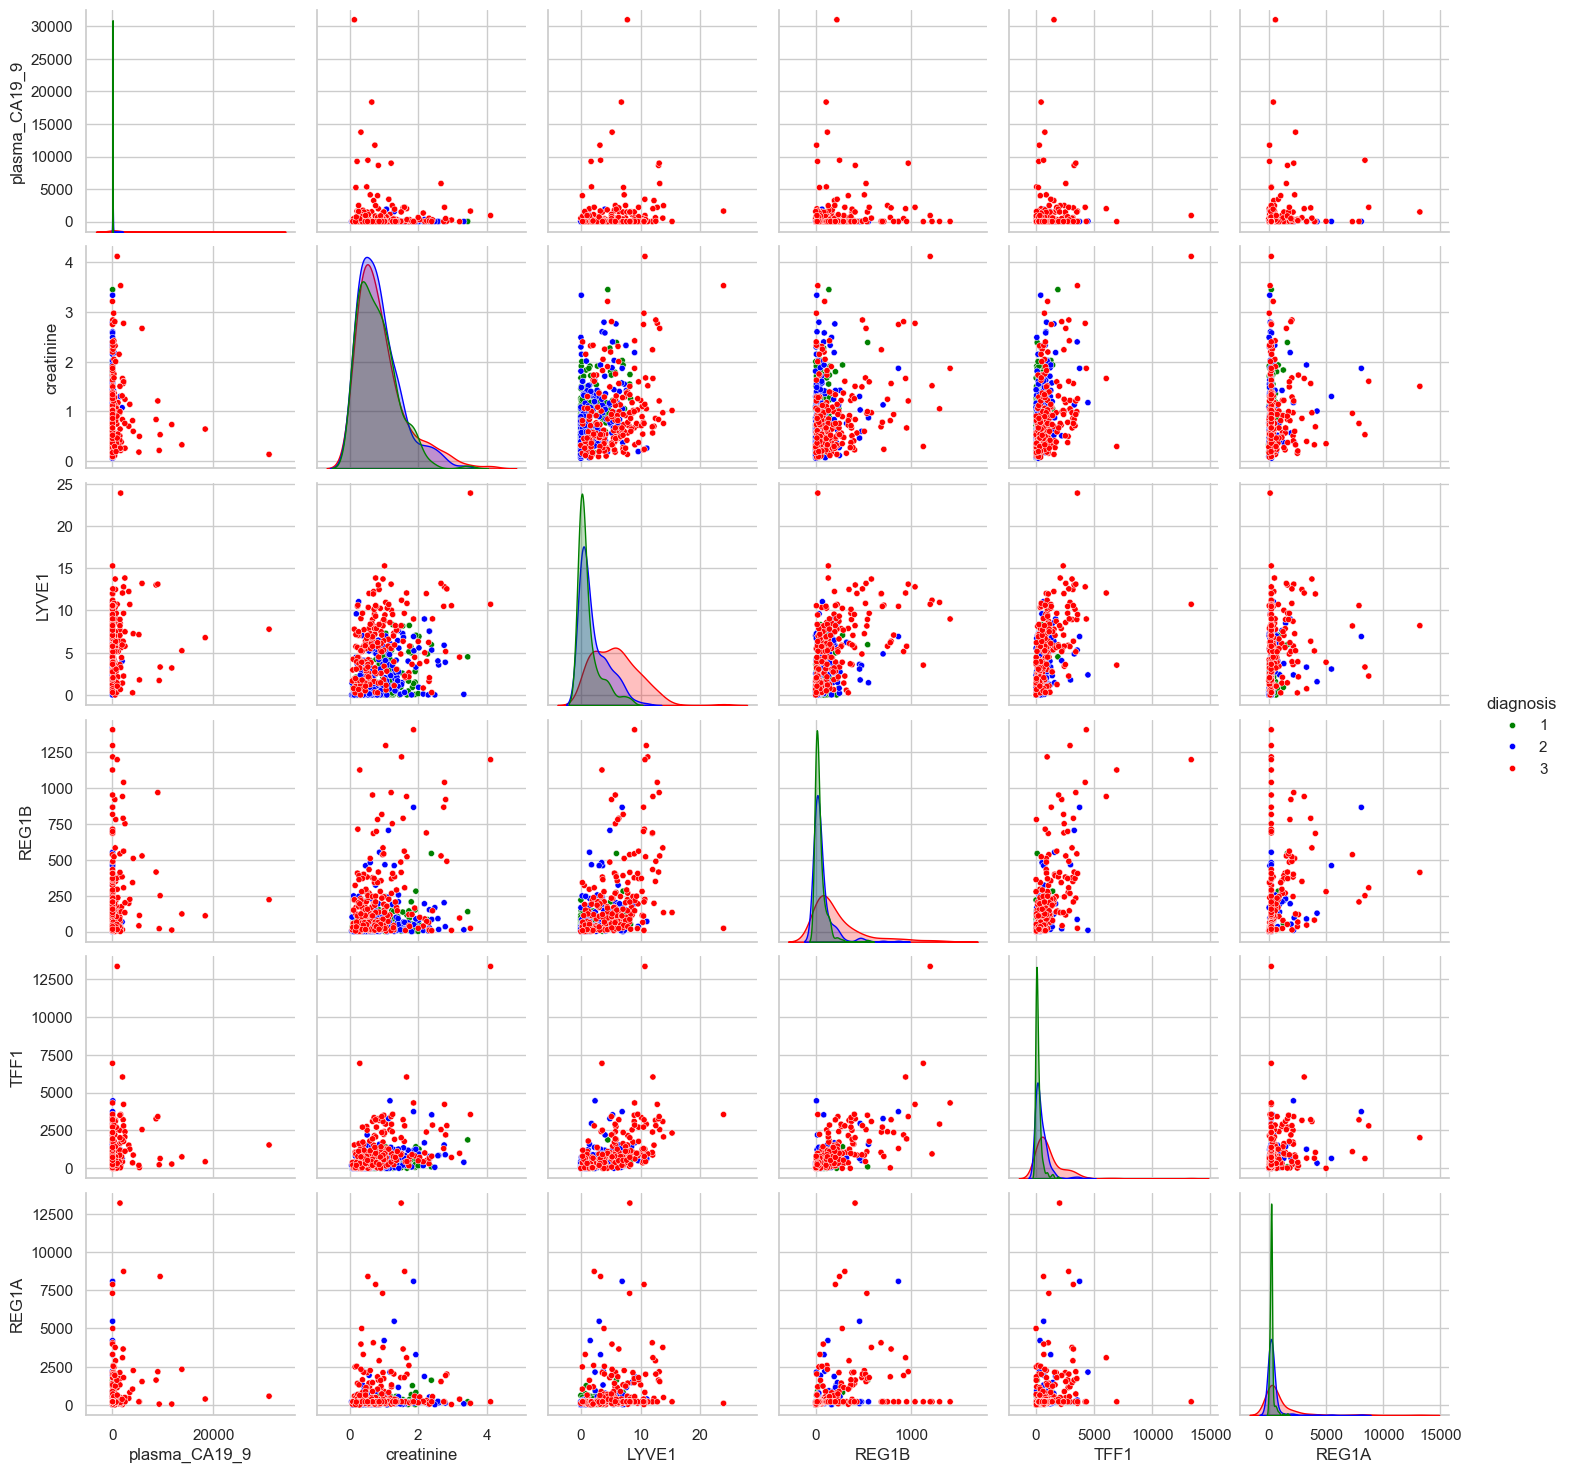

In [35]:
sns.pairplot(
    data=data,
    vars=['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
    hue='diagnosis',
    diag_kind='kde',
    plot_kws={'s': 20},  
    palette=colors)       


This heatmap shows the Pearson correlation coefficients between the variables. Pearson’s r ranges from -1 to 1:

- +1 = perfect positive linear relationship

- -1 = perfect negative linear relationship

- 0 = no linear relationship

The heatmap reveals that LYVE1 (0.54), TFF1 (0.39), and REG1B (0.38) show the strongest positive relationships with the target variable diagnosis, so these may carry the most predictive power.

In [36]:
correlations = data.corr(method='pearson').T
correlations

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
age,1.000000,0.024023,0.308251,0.111535,-0.069393,0.329805,0.204317,0.207868,0.053573
sex,0.024023,1.000000,0.169081,0.053949,0.180059,0.177008,0.157579,0.114623,0.124797
diagnosis,0.308251,0.169081,1.000000,0.237109,0.074888,0.540384,0.383516,0.392613,0.239356
plasma_CA19_9,0.111535,0.053949,0.237109,1.000000,-0.029445,0.209051,0.138283,0.145390,0.152189
creatinine,-0.069393,0.180059,0.074888,-0.029445,1.000000,0.338533,0.261906,0.397795,0.091843
LYVE1,0.329805,0.177008,0.540384,0.209051,0.338533,1.000000,0.543075,0.577363,0.263143
REG1B,0.204317,0.157579,0.383516,0.138283,0.261906,0.543075,1.000000,0.690228,0.342816
TFF1,0.207868,0.114623,0.392613,0.145390,0.397795,0.577363,0.690228,1.000000,0.292574
REG1A,0.053573,0.124797,0.239356,0.152189,0.091843,0.263143,0.342816,0.292574,1.000000


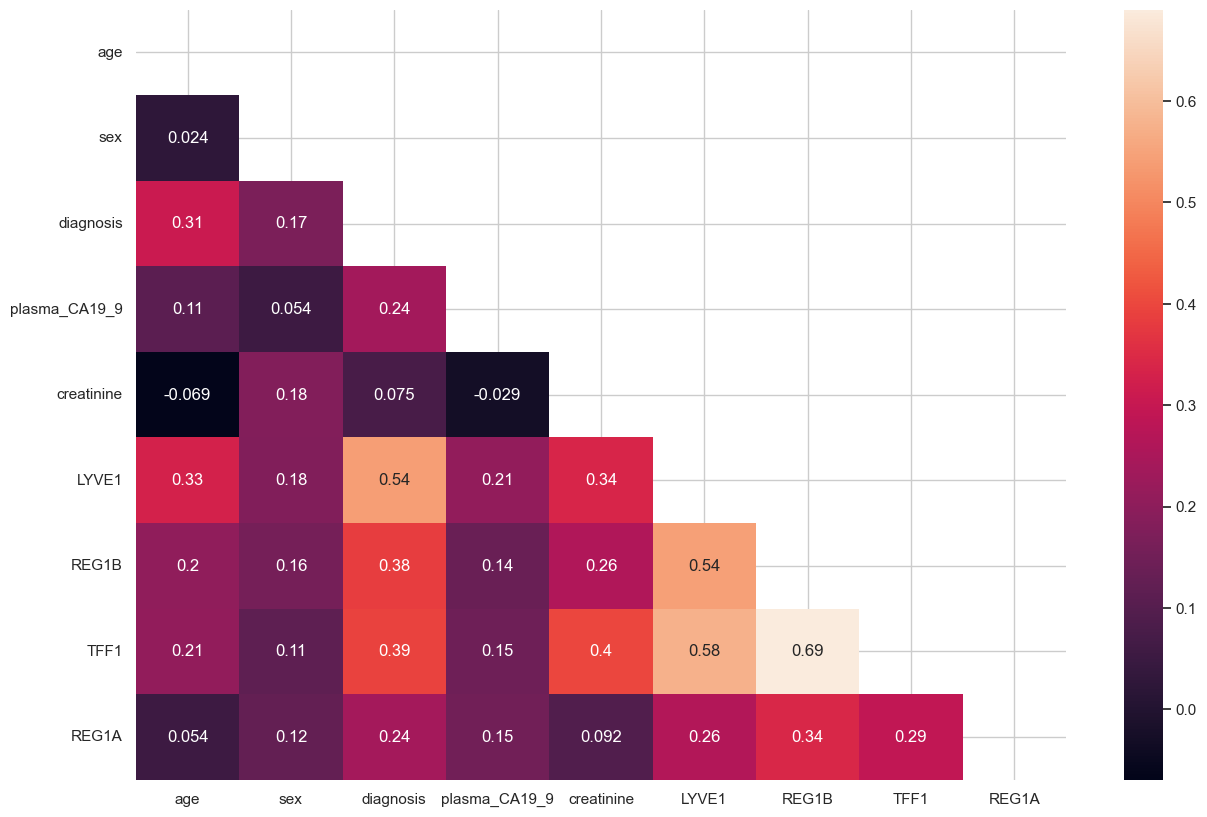

In [37]:
# Heatmap of the correlation matrix
plt.figure(figsize=(15,10))
mask=np.triu(data.corr())
sns.heatmap(data.corr().T,mask=mask, annot=True)
plt.show()


# **6.Feature selection**


In [38]:
data

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,0,1,11.7,1.83222,0.893219,52.948840,654.282174,1262.0000
1,81,0,1,26.5,0.97266,2.037585,94.467030,209.488250,228.4070
2,51,1,1,7.0,0.78039,0.145589,102.366000,461.141000,208.5385
3,61,1,1,8.0,0.70122,0.002805,60.579000,142.950000,208.5385
4,62,1,1,9.0,0.21489,0.000860,65.540000,41.088000,208.5385
...,...,...,...,...,...,...,...,...,...
585,68,1,3,26.5,0.52026,7.058209,156.241000,525.178000,208.5385
586,71,0,3,26.5,0.85956,8.341207,16.915000,245.947000,208.5385
587,63,1,3,26.5,1.36851,7.674707,289.701000,537.286000,208.5385
588,75,0,3,26.5,1.33458,8.206777,205.930000,722.523000,208.5385


In [39]:
feature_names = data.drop(columns=['diagnosis']).columns
X = data.drop(columns=['diagnosis'], axis=1).values
y = data['diagnosis'].values

In [40]:
X

array([[3.30000000e+01, 0.00000000e+00, 1.17000000e+01, ...,
        5.29488400e+01, 6.54282174e+02, 1.26200000e+03],
       [8.10000000e+01, 0.00000000e+00, 2.65000000e+01, ...,
        9.44670300e+01, 2.09488250e+02, 2.28407000e+02],
       [5.10000000e+01, 1.00000000e+00, 7.00000000e+00, ...,
        1.02366000e+02, 4.61141000e+02, 2.08538500e+02],
       ...,
       [6.30000000e+01, 1.00000000e+00, 2.65000000e+01, ...,
        2.89701000e+02, 5.37286000e+02, 2.08538500e+02],
       [7.50000000e+01, 0.00000000e+00, 2.65000000e+01, ...,
        2.05930000e+02, 7.22523000e+02, 2.08538500e+02],
       [7.40000000e+01, 1.00000000e+00, 1.48800000e+03, ...,
        4.11938275e+02, 2.02132108e+03, 1.32000000e+04]])

In [41]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [42]:
# Get the scores for all features
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X, y)

features_scores = list(zip(feature_names, selector.scores_))
features_scores.sort(key=lambda x: x[1], reverse=True)

print("All features with their chi2 scores:")
for name, score in features_scores:
    print(f"{name}: {score:.3f}")


All features with their chi2 scores:
plasma_CA19_9: 391064.020
TFF1: 165038.110
REG1A: 94047.364
REG1B: 35696.552
LYVE1: 752.013
age: 260.692
sex: 8.925
creatinine: 1.590


In [43]:
top_features = [name for name, score in features_scores[:5]]
retain = [name in top_features for name in feature_names]
X_selected = X[:, retain]

In [44]:
X_selected

array([[1.17000000e+01, 8.93219200e-01, 5.29488400e+01, 6.54282174e+02,
        1.26200000e+03],
       [2.65000000e+01, 2.03758500e+00, 9.44670300e+01, 2.09488250e+02,
        2.28407000e+02],
       [7.00000000e+00, 1.45588900e-01, 1.02366000e+02, 4.61141000e+02,
        2.08538500e+02],
       ...,
       [2.65000000e+01, 7.67470700e+00, 2.89701000e+02, 5.37286000e+02,
        2.08538500e+02],
       [2.65000000e+01, 8.20677700e+00, 2.05930000e+02, 7.22523000e+02,
        2.08538500e+02],
       [1.48800000e+03, 8.20095800e+00, 4.11938275e+02, 2.02132108e+03,
        1.32000000e+04]])

# **7. Dataset splitting and scaling**
The dataset is split into training (80%) and testing (20%) sets. The training data is used to fit the models and should be representative of the entire dataset, maintaining the same class distribution to ensure balanced learning. After training, the model is evaluated on the testing set to assess its performance on unseen data.

In [45]:
print(f"Original X shape: {X.shape}")
print(f"Original y shape: {y.shape}")

print(f"Feature selection X shape: {X_selected.shape}")
print(f"Feature selection y shape: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Original X shape: (590, 8)
Original y shape: (590,)
Feature selection X shape: (590, 5)
Feature selection y shape: (590,)
X_train shape: (472, 5)
X_test shape: (118, 5)
y_train shape: (472,)
y_test shape: (118,)


In [46]:
# Standardiztion  features to mean 0 and standard deviation 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **7.Random Forest**

Random Forest is an ensemble learning technique which builds multiple decision trees during training and combines their outputs to produce a more accurate and stable prediction. By aggregating the results of many individual trees, RF reduces overfitting and improves the model's ability to generalize to new data.  By default, RF uses hard voting for classification meaning that each each decision tree in the forest casts a vote for a class, and the class with the most votes becomes the final prediction.

### 7.1 RF with default parameters


In [47]:
def model_train(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model, model.get_params()

def model_test(model, X_test, y_test, metrics_csv_path, report_csv_path):
    '''Evaluates the model, saves test metrics and classification report to CSV, and returns them'''
    y_pred = model.predict(X_test)

    # 1. metrics
    test_metrics = {
        'accuracy':       accuracy_score(y_test, y_pred),
        'f1_macro':       f1_score(y_test, y_pred, average='macro'),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_macro':    recall_score(y_test, y_pred, average='macro'),
        'mcc':             matthews_corrcoef(y_test, y_pred)
    }
    metrics_df = pd.DataFrame([test_metrics])
    metrics_df.to_csv(metrics_csv_path, index=False)

    # 2. classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv(report_csv_path)

    # 3.  confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    print("Test Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", cm)

    return metrics_df, report_df, cm




def model_workflow(model, X_train, X_test, y_train, y_test, metrics_csv_path='test_metrics.csv',
    report_csv_path='classification_report.csv'):
    '''Trains a model using default parameters, prints model parameters, and evaluates the model'''
    
    # 1. Train
    fitted_model, model_parameters = model_train(model, X_train, y_train)

    # 2. Print model parameters
    print("\nModel parameters:")
    for param, value in model_parameters.items():
        print(f"  {param}: {value}")

    # 3. Test 
    metrics_df, report_df, cm = model_test(
        fitted_model,
        X_test,
        y_test,
        metrics_csv_path=metrics_csv_path,
        report_csv_path=report_csv_path
    )

    return metrics_df, report_df, cm


def plot_cm(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



In [48]:
rf_model = RandomForestClassifier(random_state=42)

rf_def_metrics, rf_def_report, rf_def_cm = model_workflow(
    rf_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    metrics_csv_path="rf_def_test_metrics.csv",
    report_csv_path="rf_def_classification_report.csv")



Model parameters:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: None
  criterion: gini
  max_depth: None
  max_features: sqrt
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 2
  min_weight_fraction_leaf: 0.0
  monotonic_cst: None
  n_estimators: 100
  n_jobs: None
  oob_score: False
  random_state: 42
  verbose: 0
  warm_start: False
Test Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.68      0.69        37
           2       0.61      0.68      0.64        41
           3       0.84      0.78      0.81        40

    accuracy                           0.71       118
   macro avg       0.72      0.71      0.71       118
weighted avg       0.72      0.71      0.71       118

Confusion Matrix:
 [[25  9  3]
 [10 28  3]
 [ 0  9 31]]


In [49]:
rf_def_metrics

,accuracy,f1_macro,precision_macro,recall_macro,mcc
0,0.711864,0.714439,0.720273,0.711201,0.568047


In [50]:
rf_def_report

,precision,recall,f1-score,support
1,0.714286,0.675676,0.694444,37.000000
2,0.608696,0.682927,0.643678,41.000000
3,0.837838,0.775000,0.805195,40.000000
accuracy,0.711864,0.711864,0.711864,0.711864
macro avg,0.720273,0.711201,0.714439,118.000000
weighted avg,0.719480,0.711864,0.714348,118.000000


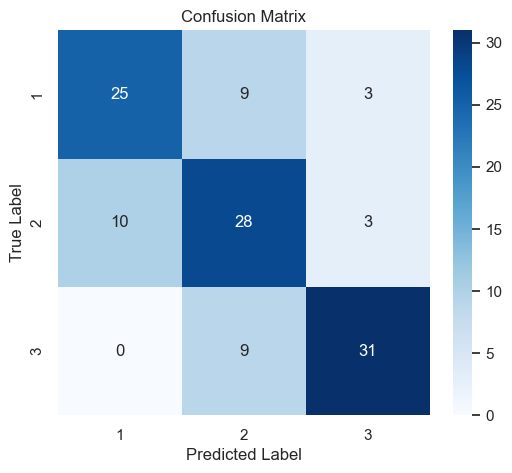

In [51]:
plot_cm(rf_def_cm)

### 7.2 RF with optimized hyperparameters


Hyperparameter tuning is the process of selecting the best combination of hyperparameters to improve model performance. Unlike model parameters that are learned during training, hyperparameters are set before training and influence how the model learns.

In this case I'm using **5-fold cross-validation** to evaluate different combinations of hyperparameters and select the one that generalizes best to unseen data.

* **n\_estimators** = Number of trees in the forest (more trees generally improve accuracy but increase computation time)

* **max\_depth** = Maximum depth of each decision tree (deeper trees can capture complex patterns but may lead to overfitting)

* **max\_features** = Number of features considered when looking for the best split.

* **min\_samples\_leaf** = Minimum number of samples that must be present in a leaf node.

* **min\_samples\_split** = Minimum number of samples required to split an internal node.

* **bootstrap** = Whether bootstrap samples (random sampling with replacement) are used to train each tree. It adds randomness to help reduce overfitting.



In [52]:
def get_best_model(model, param_grid, X_train, y_train):
    ''' Performs GridSearchCV for hyperparameter tuning and returns the best model and parameters'''
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1,verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return best_model, best_params

In [53]:
rf_param_grid = {
    'n_estimators': [50, 100, 500,1000],
    'max_depth' : [3,5,10,20,None],
    'max_features' : ["sqrt","log2", None],
    'min_samples_leaf' : [1,2,4],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
} 

rf_model = RandomForestClassifier(random_state=42)


best_rf_model, best_rf_params = get_best_model(rf_model, rf_param_grid,  X_train_scaled, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Best cross-validation score: 0.6971


In [54]:
best_rf_params

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [55]:
best_rf_model

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=1000,
                       random_state=42)

In [56]:
rf_opt_metrics, rf_opt_report,rf_opt_cm = model_test(
    best_rf_model,
    X_test_scaled, 
    y_test,
    metrics_csv_path='rf_opt_test_metrics.csv',
    report_csv_path='rf_opt_classification_report.csv')

Test Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.68      0.70        37
           2       0.64      0.68      0.66        41
           3       0.82      0.82      0.82        40

    accuracy                           0.73       118
   macro avg       0.73      0.73      0.73       118
weighted avg       0.73      0.73      0.73       118

Confusion Matrix:
 [[25  9  3]
 [ 9 28  4]
 [ 0  7 33]]


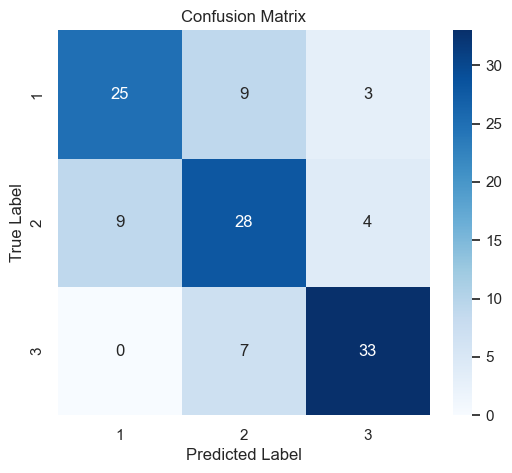

In [57]:
plot_cm(rf_opt_cm)

# 8. **Support vector machine (SVM)**

The  idea of SVM is to find the optimal hyperplane that separates classes with the maximum margin, meaning the greatest distance between the hyperplane and the nearest data points from each class (called support vectors).
SVM doesn’t naturally handle more than two classes, so it relies on two strategies:
- One-vs-Rest (OvR): Trains one classifier per class, treating the current class as positive and all others as negative
- One-vs-One (OvO): Trains a separate classifier for every possible pair of classes

### 8.1 SVM on original scaled data


In [58]:
svm_model = SVC(random_state=42)

svm_def_metrics, svm_def_class_report, svm_def_conf_matrix = model_workflow(
    svm_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    metrics_csv_path="svm_def_test_metrics.csv",
    report_csv_path="svm_def_classification_report.csv")



Model parameters:
  C: 1.0
  break_ties: False
  cache_size: 200
  class_weight: None
  coef0: 0.0
  decision_function_shape: ovr
  degree: 3
  gamma: scale
  kernel: rbf
  max_iter: -1
  probability: False
  random_state: 42
  shrinking: True
  tol: 0.001
  verbose: False
Test Classification Report:
               precision    recall  f1-score   support

           1       0.55      0.84      0.67        37
           2       0.61      0.27      0.37        41
           3       0.75      0.82      0.79        40

    accuracy                           0.64       118
   macro avg       0.64      0.64      0.61       118
weighted avg       0.64      0.64      0.60       118

Confusion Matrix:
 [[31  3  3]
 [22 11  8]
 [ 3  4 33]]


In [59]:
svm_def_metrics

,accuracy,f1_macro,precision_macro,recall_macro,mcc
0,0.635593,0.608421,0.638228,0.64371,0.481268


In [60]:
svm_def_class_report

,precision,recall,f1-score,support
1,0.553571,0.837838,0.666667,37.000000
2,0.611111,0.268293,0.372881,41.000000
3,0.750000,0.825000,0.785714,40.000000
accuracy,0.635593,0.635593,0.635593,0.635593
macro avg,0.638228,0.643710,0.608421,118.000000
weighted avg,0.640150,0.635593,0.604944,118.000000


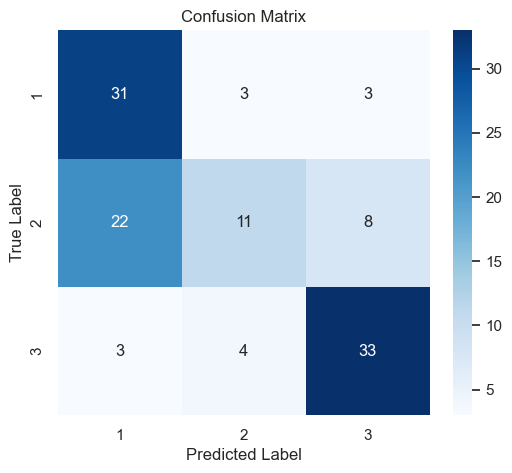

In [61]:
plot_cm(svm_def_conf_matrix)

### 8.2 SVM PCA data


After performing a Principal Component Analysis (PCA), which is a linear dimensionality reduction technique, I generated an elbow plot to visualize the amount of variance explained by each principal component. The optimal number of components is typically chosen where the curve starts to flatten (this is the "elbow"). However, since we only have a few components, I decide to retain all of them. 
By plotting the data in 2D using the first two PCs, I observe that the classes are not linearly separable, indicating that a simple linear SVM may struggle without using kernel tricks.


In [62]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


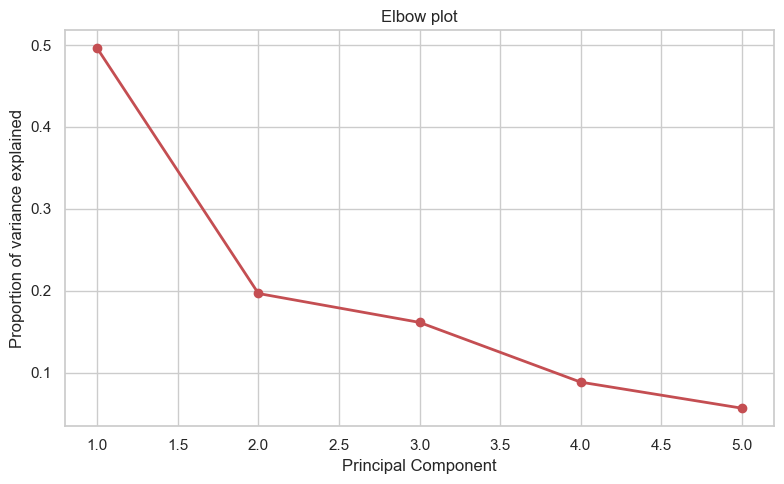

In [63]:
PC_values = np.arange(1, pca.n_components_ + 1)
plt.figure(figsize=(8, 5))
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Elbow plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of variance explained')
plt.grid(True)
plt.tight_layout()
plt.show()

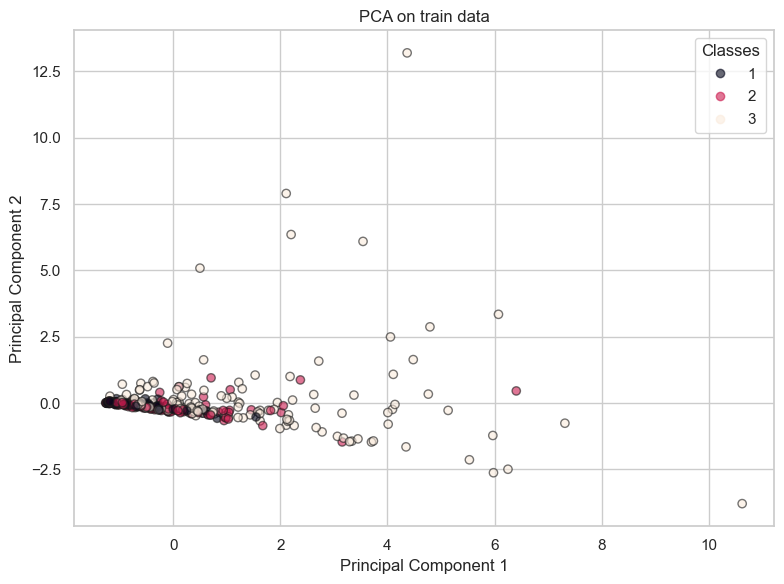

In [64]:
X_pca_2d = X_train_pca[:, :2]  

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_train, alpha=0.6, edgecolors='k')
plt.title('PCA on train data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.tight_layout()
plt.show()

In [65]:
svm_model = SVC(random_state=42)
svm_pca_metrics, svm_pca_class_report, svm_pca_conf_matrix = model_workflow(
    svm_model,
    X_train_pca,
    X_test_pca, 
    y_train, 
    y_test,
    metrics_csv_path="svm_pca_test_metrics.csv",
    report_csv_path="svm_pca_classification_report.csv")



Model parameters:
  C: 1.0
  break_ties: False
  cache_size: 200
  class_weight: None
  coef0: 0.0
  decision_function_shape: ovr
  degree: 3
  gamma: scale
  kernel: rbf
  max_iter: -1
  probability: False
  random_state: 42
  shrinking: True
  tol: 0.001
  verbose: False
Test Classification Report:
               precision    recall  f1-score   support

           1       0.55      0.84      0.67        37
           2       0.61      0.27      0.37        41
           3       0.75      0.82      0.79        40

    accuracy                           0.64       118
   macro avg       0.64      0.64      0.61       118
weighted avg       0.64      0.64      0.60       118

Confusion Matrix:
 [[31  3  3]
 [22 11  8]
 [ 3  4 33]]


In [66]:
svm_pca_metrics

,accuracy,f1_macro,precision_macro,recall_macro,mcc
0,0.635593,0.608421,0.638228,0.64371,0.481268


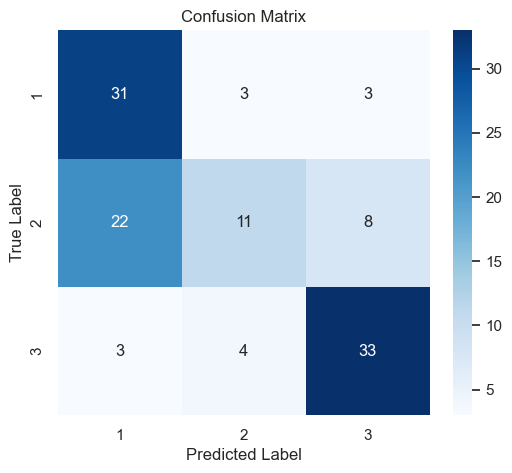

In [67]:
plot_cm(svm_pca_conf_matrix)

### 8.3 SVM with optimized hyperparamters



In this case I'm using 5-fold cross-validation to evaluate different combinations of hyperparameters and select the one that generalizes best to unseen data.

* **kernel** = `'rbf'` (Radial Basis Function) maps non-linearly separable data into a higher-dimensional space to handle non-linear decision boundaries.
  It was not useful to try a linear kernel for this dataset.

* **C** = Regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors.

  * Lower values allow a larger margin but more misclassifications (underfitting).
  * Higher values aim for fewer misclassifications, possibly at the risk of overfitting.

* **gamma** = Defines the influence radius of each training point on the decision boundary.

  * Low gamma: broader influence (smoother decision boundary).
  * High gamma: limited influence (can lead to overfitting).

* **decision\_function\_shape** = Strategy used for multi-class classification.

  * `'ovr'` (One-vs-Rest): Fits one classifier per class.
  * `'ovo'` (One-vs-One): Fits classifiers for every pair of classes, often more precise but computationally heavier.



In [68]:
svm_param_grid = {
    'kernel': ['rbf'],  
    'C': [0.01, 0.1, 1, 10, 100], 
    'gamma': ['scale', 0.01, 0.1, 1, 10],  
    'decision_function_shape': ['ovr', 'ovo'],

}

In [69]:
svm_model = SVC(random_state=42)

best_svm_model, best_svm_params = get_best_model(svm_model, svm_param_grid, X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'C': 10, 'decision_function_shape': 'ovr', 'gamma': 10, 'kernel': 'rbf'}
Best cross-validation score: 0.6441


In [70]:
best_svm_model

SVC(C=10, gamma=10, random_state=42)

In [71]:
svm_opt_metrics, svm_opt_report,svm_opt_cm = model_test(
    best_svm_model,
    X_test_scaled, 
    y_test,
    metrics_csv_path='svm_opt_test_metrics.csv',
    report_csv_path='svm_opt_classification_report.csv')

Test Classification Report:
               precision    recall  f1-score   support

           1       0.63      0.70      0.67        37
           2       0.60      0.51      0.55        41
           3       0.76      0.80      0.78        40

    accuracy                           0.67       118
   macro avg       0.67      0.67      0.67       118
weighted avg       0.67      0.67      0.67       118

Confusion Matrix:
 [[26  7  4]
 [14 21  6]
 [ 1  7 32]]


# 9. **Neural nertwork**

### 9.1 One-hot encoding


Before training the neural network, I need to one-hot encoded the class labels (1, 2, 3 → [0, 0, 1], [0, 1, 0], [1, 0, 0]). NNs use the softmax activation function in the output layer for multi-class classification which outputs a probability distribution over all classes, so the true labels must also be in a compatible format. In addition one-hot encoding ensures the loss function (like categorical cross-entropy) can compare predicted probabilities to the correct class vector during training.

In [72]:
y_train[:10]

array([1, 3, 3, 2, 2, 1, 2, 2, 1, 3])

In [73]:
y_train_zero = y_train - 1
y_test_zero= y_test - 1


In [74]:
y_train_zero[:10]


array([0, 2, 2, 1, 1, 0, 1, 1, 0, 2])

In [75]:
y_train_ohe = to_categorical(y_train_zero, num_classes=3)
y_test_ohe = to_categorical(y_test_zero, num_classes=3)

In [76]:
y_train_ohe[:10]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [77]:
y_test_ohe[:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

### 9.2 NN tuning


In this case, I’m tuning the neural network using Keras Tuner*to find the best combination of architecture and training settings (https://www.digitalocean.com/community/tutorials/hyperparameter-optimization-with-keras-tuner)

* **Input layer:** Takes 5 input features 

* **Hidden layers:**

  * Number of layers (`num_layers`) varies from 1 to 5.
  * Each layer’s units (`units_i`) range from 16 to 64 with step 16
  * Activation function: `"relu"`.
  * **L2 regularization** and **dropout** are applied to help prevent overfitting

* **Output layer:**

  * Dense layer with 3 units (for 3 classes) and **softmax** activation for multi-class classification

* **Optimizer:**

  * Choice between `"adam"` and `"sgd"`
  * Learning rate is tuned between `1e-4` and `1e-2` 

* **Compilation:**

  * Loss function: `categorical_crossentropy` 
  * Metric: `accuracy`


In [78]:
# Define the model builder function
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(5,)))

    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=16, max_value=64, step=16),
            activation="relu", 
            kernel_regularizer=keras.regularizers.l2(
                hp.Float("l2", 1e-6, 1e-2, sampling="log"))
        ))
        model.add(layers.Dropout(hp.Float("dropout", 0.1, 0.5, step=0.1)))

    model.add(layers.Dense(3, activation="softmax"))

    optimizer_name = hp.Choice("optimizer", ["adam", "sgd"])
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizer = keras.optimizers.Adam(learning_rate) if optimizer_name == "adam" else keras.optimizers.SGD(learning_rate)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


Instead of using a grid search as earlier, here a Random Search is employed to explore combinations of hyperparameters. This search aims to find the best model based on validation accuracy and it's limited to a maximum of 30 trials.

In [79]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=30,
    seed=42,  
    overwrite=True,
    directory="random_search_output",
    project_name="random_search_proj"
)


2025-05-19 10:39:12.387207: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-19 10:39:12.387427: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-19 10:39:12.387439: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-19 10:39:12.387724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-19 10:39:12.387748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Early stopping is used to prevent overfitting by monitoring the validation loss  and stopping training if it does not improve for 5 consecutive epochs (patience=5).
The tuner runs the search on the training data with a 20% validation split.
Each model is trained for up to 30 epochs per trial, with training progress displayed (verbose=2).

In [80]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

tuner.search(
    X_train_scaled, y_train_ohe,
    validation_split=0.2,
    epochs=30,
    callbacks=[stop_early],
    verbose=2
)


Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.43157893419265747

Best val_accuracy So Far: 0.49473685026168823
Total elapsed time: 00h 06m 27s


In [81]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:")
for key, val in best_hps.values.items():
    print(f"{key}: {val}")



Best Hyperparameters:
num_layers: 1
units_0: 48
l2: 7.883914384218181e-06
dropout: 0.2
optimizer: adam
learning_rate: 0.007177664122743156
units_1: 32
units_2: 32
units_3: 32


### 9.3 NN training


The best hyperparameters found during tuning are used to build the final model which is then then retrained on the entire training dataset.

In [82]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_scaled, y_train_ohe,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.4644 - loss: 1.1281 - val_accuracy: 0.4526 - val_loss: 1.0369
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5768 - loss: 0.8454 - val_accuracy: 0.4421 - val_loss: 1.0274
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5764 - loss: 0.8172 - val_accuracy: 0.4421 - val_loss: 0.9887
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5567 - loss: 0.8179 - val_accuracy: 0.4211 - val_loss: 0.9691
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5874 - loss: 0.8003 - val_accuracy: 0.4316 - val_loss: 0.9688
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5833 - loss: 0.8002 - val_accuracy: 0.4526 - val_loss: 0.9698
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6008 - loss: 0.7985 - val_accuracy: 0.4737 - val_loss: 0.9604
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6090 - loss: 0.7924 - val_accuracy: 0.4526 - 

### 9.4 NN evaluation


In [83]:
eval_result = best_model.evaluate(
    X_test_scaled,
    y_test_ohe,
    batch_size=32,
    verbose=2
)

print(f"\nTest loss:{eval_result[0]:.4f}")
print(f"Test accuracy:{eval_result[1]:.4f}")

4/4 - 0s - 53ms/step - accuracy: 0.6525 - loss: 0.7383

Test loss:0.7383
Test accuracy:0.6525


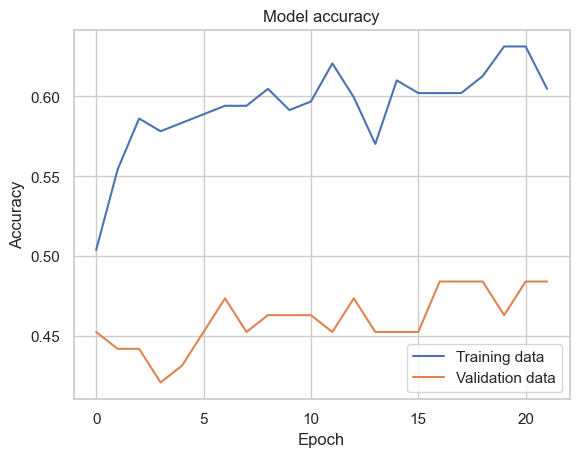

In [84]:
# Visualize accuracy values 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training data', 'Validation data'], loc='lower right')

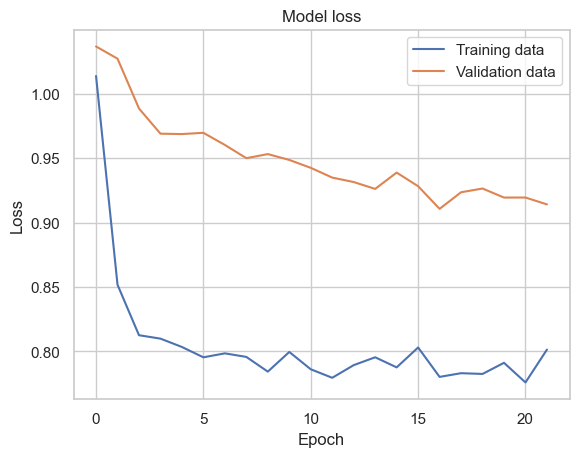

In [85]:
# Visualize loss values 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training data', 'Validation data'], loc='upper right')

I update my initial function to convert class probabilities to class labels

In [86]:
def model_test_nn(model, X_test, y_test, metrics_csv_path, report_csv_path):
    
    # 1. Get predicted probabilities and convert to class labels
    probs = model.predict(X_test)
    y_pred = probs.argmax(axis=1) + 1 

    # 2. metrics
    test_metrics = {
        'accuracy':        accuracy_score(y_test, y_pred),
        'f1_macro':        f1_score(y_test, y_pred, average='macro'),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_macro':    recall_score(y_test, y_pred, average='macro'),
        'mcc':             matthews_corrcoef(y_test, y_pred)
    }
    metrics_df = pd.DataFrame([test_metrics])
    metrics_df.to_csv(metrics_csv_path, index=False)

    # 3. classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv(report_csv_path)

    # 4. confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Test Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", cm)

    return metrics_df, report_df, cm


In [87]:
nn_rs_metrics, nn_rs_report, nn_rs_cm = model_test_nn(
    best_model, 
    X_test_scaled, 
    y_test,
    metrics_csv_path="nn_rs_test_metrics.csv",
    report_csv_path="nn_rs_classification_report.csv")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Classification Report:
               precision    recall  f1-score   support

           1       0.53      0.84      0.65        37
           2       0.64      0.34      0.44        41
           3       0.84      0.80      0.82        40

    accuracy                           0.65       118
   macro avg       0.67      0.66      0.64       118
weighted avg       0.67      0.65      0.64       118

Confusion Matrix:
 [[31  3  3]
 [24 14  3]
 [ 3  5 32]]


In [88]:
nn_rs_metrics

,accuracy,f1_macro,precision_macro,recall_macro,mcc
0,0.652542,0.639196,0.670984,0.659767,0.50496


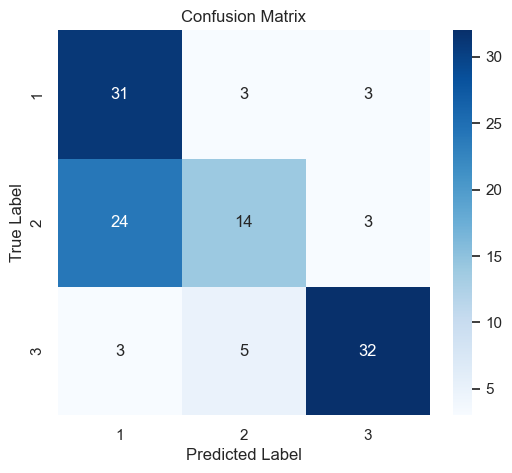

In [89]:
plot_cm(nn_rs_cm)

# 10. **Spider plot**

I concatenate all the metrics of the models together to visualize them with a spider/radar plot (https://medium.com/@reinapeh/creating-a-complex-radar-chart-with-python-31c5cc4b3c5c)

In [125]:
rf_def_metrics["Model"] = "Random Forest (Default)"
rf_opt_metrics["Model"] = "Random Forest (Optimized)"
svm_def_metrics["Model"] = "SVM (Default)"
svm_pca_metrics["Model"] = "SVM (PCA)"
svm_opt_metrics["Model"] = "SVM (Optimized)"
nn_rs_metrics["Model"] = "Neural Network (Random Search)"

models_metrics = pd.concat([
    rf_def_metrics,
    rf_opt_metrics,
    svm_def_metrics,
    svm_pca_metrics,
    svm_opt_metrics,
    nn_rs_metrics
], ignore_index=True)

models_metrics = models_metrics.set_index("Model")


In [126]:
models_metrics

,accuracy,f1_macro,precision_macro,recall_macro,mcc
Model,,,,,
Random Forest (Default),0.711864,0.714439,0.720273,0.711201,0.568047
Random Forest (Optimized),0.728814,0.729350,0.732219,0.727868,0.592890
SVM (Default),0.635593,0.608421,0.638228,0.643710,0.481268
SVM (PCA),0.635593,0.608421,0.638228,0.643710,0.481268
SVM (Optimized),0.669492,0.666595,0.665350,0.671633,0.506261
Neural Network (Random Search),0.652542,0.639196,0.670984,0.659767,0.504960


In [108]:
metrics = models_metrics.columns.tolist()
metrics

['accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'mcc']

In [124]:

def plot_radar_chart(data, metrics, title):
    N = len(metrics)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    theta += theta[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_title(title, y=1.10, fontsize=18)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines['polar'].set_color('lightgrey')

    # A simple color palette (one per row)
    colors = sns.color_palette("tab10", n_colors=len(data))

    # Plot each model
    for idx, (model_name, row) in enumerate(data.iterrows()):
        values = row[metrics].tolist()
        values += values[:1]  # close the circle
        ax.plot(theta, values,
                color=colors[idx],
                linewidth=2,
                label=model_name)
        ax.fill(theta, values,
                color=colors[idx],
                alpha=0.25)

    # Set the axis labels
    ax.set_xticks(theta[:-1])
    ax.set_xticklabels(metrics, fontsize=12)
    
    # Adjust the radial scale: from 0 to max + small margin
    max_val = data[metrics].max().max()
    ax.set_ylim(0, max_val * 1.1)
    ax.set_yticks(np.linspace(0, max_val, 5))
    ax.set_yticklabels([f"{v:.2f}" for v in np.linspace(0, max_val, 5)], fontsize=10)

    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()
    return fig


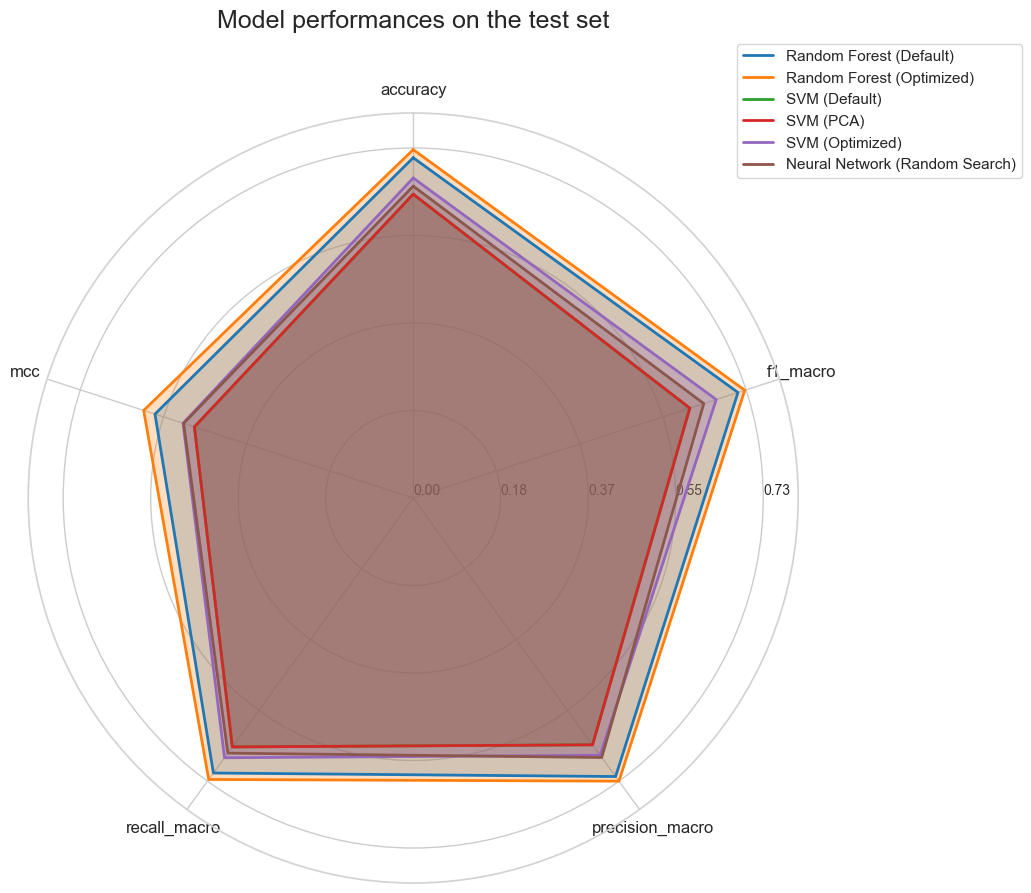

In [123]:
fig = plot_radar_chart(models_metrics, metrics, title="Model performances on the test set")
plt.show()

From the plot we can assess that for this task:
- The model with the best overall performance is the Random Forest with optimized parameters, followed by a slightly lower performance from the same model with default parameters.
- The Neural Network and the optimized SVM have the same MCC and recall, while the SVM stands out with higher accuracy and F1 score.
- The least performing models are the SVM with default parameters trained on the scaled data and the SVM trained on the principal components, which essentially have the same performance